# Swiss Housing Price Predictor 🏠💰

Hello, we are Tobias, Sascha, and Florian. Our goal for this project is to build a predictive model for Swiss housing prices. We aim to achieve this by leveraging current web data. 

![Family house during golden hour.](resources\Peach-Tree-House.png)
<br><small>[Image Source](https://archivaldesigns.com/collections/all/products/peach-tree-ii-house-plan?view=new2), Retrieved April 29, 2024</small>


This project will involve several steps:

1. **Data Collection**: Scrape housing data from various online sources.
2. **Preprocessing**: Clean and format the data for analysis.
3. **Exploratory Data Analysis**: Understand the data and find any interesting trends.
4. **Feature Engineering**: Create new features from the existing data to improve our model's performance.
5. **Model Building**: Train a machine learning model on our processed data.
6. **Evaluation**: Test our model's performance and make any necessary adjustments.

Our aim is that our model will be able to accurately predict housing prices, providing valuable insights for both buyers and sellers in the Swiss housing market. 

You can check out our code [here on GitHub](https://github.com/meichflo/ADS_Project_group3).

> "The only way to do great work is to love what you do." - Steve Jobs

## Table of Contents

- [Imports](#imports)
- [Data Collection](#data-collection)
    - [Web Scraping from Immoscout24](#Web-Scraping-from-Immoscout24)
    - [Cleansing of Scraped Data](#Cleansing-of-Scraped-Data)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
    - [Price is missing?](#Price-is-missing?)
    - [Data Transformation](#Data-Transformation)
    - [Data Cleaning](#Data-Cleaning)
    - [Feature Engeneering](#Feature-Engeneering)
- [Database](#database)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Outlier detection](#Outlier-detection)
    - [Correlation](#correlation)
    - [Data distribution](#Datadistribution)

- [Data Preperation](#data-preperation)
    - [Feature Scaling](#Feature-Scaling)
    - [Data Seperation](#Data-Seperation)
- [Model Building](#model-building)
    - [Choose Model(s)](#Choose-Model(s))
    - [Train Model](#Train-Model)
    - [Model Evaluation](#Model-Evaluation)
    - [Fine-Tune the Model](#Fine-Tune-the-Model)
    - [Final Model Run](#Final-Model-Run)
- [Conclusion](#conclusion)
- [Sources](#sources)
---
## Imports

In [ ]:
!pip install -r requirements.txt

In [1]:
# Standard library imports
import os  # For operating system interactions
import re  # For regular expressions
import json  # For JSON file manipulation
import ast  # For abstract syntax trees
import time  # For time-related functions
import random  # For generating random numbers
from datetime import datetime  # For date and time manipulations
import warnings  # For managing warnings

# Third-party library imports
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import folium  # For interactive map visualization
import googlemaps  # For Google Maps API interactions
from bs4 import BeautifulSoup  # For parsing HTML and XML documents
from prettytable import from_csv  # For creating tables from CSV files

# Plotting libraries
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static plots
import matplotlib.image as mpimg  # For reading images to plot

# Web scraping libraries
from selenium import webdriver  # For controlling web browsers
from selenium.webdriver.common.by import By  # For locating elements
from selenium.webdriver.common.keys import Keys  # For keyboard interactions
from selenium.webdriver.chrome.options import Options  # For Chrome browser options
from selenium.webdriver.chrome.service import Service  # For managing ChromeDriver
from selenium.webdriver.support.ui import WebDriverWait  # For waiting until conditions are met
from selenium.webdriver.support import expected_conditions as EC  # For expected conditions
from webdriver_manager.chrome import ChromeDriverManager  # For managing ChromeDriver installation

# Machine learning libraries
from sklearn.preprocessing import minmax_scale  # For scaling data
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating model performance
from sklearn.tree import DecisionTreeRegressor, plot_tree  # For decision tree models and plotting
from sklearn.ensemble import RandomForestRegressor  # For random forest models
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
import tensorflow as tf  # For deep learning
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Dense, Dropout  # For building neural network layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # For optimization algorithms

# Settings
warnings.filterwarnings("ignore")  # To ignore warnings

# Print the current working directory
print(f'Current working directory: {os.getcwd()}')



Current working directory: c:\Users\FMeic\data_science\ADS_Project_group3


## Data Collection
In this phase, we focus on gathering the necessary data for our project. We start by identifying the data sources, which can include databases, APIs, and public datasets. Once we have determined where the data will come from, we proceed with the data acquisition process. This involves collecting the data through various methods such as web scraping, querying databases, or accessing data through APIs.

### Web Scraping from Immoscout24
As part of our data collection efforts for the immo-project, we will be utilizing web scraping techniques to extract relevant information from the swiss immo plattform **Immoscout24**. This will allow us to gather valuable data that will contribute to our project.

In [ ]:
# List of user agents to rotate through
ua_list = ["Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
           "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
           "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0"]

# Set up the Chrome driver with a random user agent and headless mode
opts = Options()
opts.add_argument("--headless")
opts.add_argument("user-agent=" + random.choice(ua_list))

#service = Service(executable_path=r'C:\Tools\chromedriver\chromedriver.exe')
service = Service(executable_path=r'/Users/tobiaskoller/Library/CloudStorage/OneDrive-ZHAW/2. Semester/Applied Data Science/tools/chromedriver-mac-x64/chromedriver')

# Chrome-Driver
driver = webdriver.Chrome(service=service, options=opts)

# Base URL of the website to scrape
base_url = 'https://www.immoscout24.ch/de/immobilien/mieten/kanton-zuerich?pn='

# Initialize an empty list to store scraped data
all_detail_urls = []


current_page = 1    # Start with page 1 of the search results
max_pages = 50  # Specify the maximum number of pages to scrape

# Loop through all pages to extract URLs of property listings
while current_page <= max_pages:
    driver.get(base_url + str(current_page))     # Load the website
    source = driver.page_source                  # Get the full content of the website
    soup = BeautifulSoup(source, 'html.parser')  # Parse HTML content with BeautifulSoup
    
    # Extract detail page URLs
    listing_links_elements = soup.find_all('a', class_='HgCardElevated_content_uir_2 HgCardElevated_link_EHfr7')
    detail_urls = [link['href'] for link in listing_links_elements if 'href' in link.attrs]
    # Assuming the href might not be a full URL, prepend base URL if needed
    full_urls = ['https://www.immoscout24.ch' + url if not url.startswith('http') else url for url in detail_urls]
    all_detail_urls.extend(full_urls)

    # Increment the page number
    current_page += 1

# Initialize empty lists to store the scraped data
all_detailed_id = []
all_detailed_title = []
all_detailed_address = []
all_detailed_price = []
all_detailed_rooms = []
all_detailed_squareMeters = []
all_detailed_descriptions = [] 
all_detailed_coreAttributes = []
all_detailed_features = []


test_urls = ['https://www.immoscout24.ch/mieten/4000855763', 'https://www.immoscout24.ch/mieten/4000894477']

# Loop through all detail URLs to extract detailed information
for url in all_detail_urls:
    driver.get(url)
    detailed_source = driver.page_source
    detailed_soup = BeautifulSoup(detailed_source, 'html.parser')

    detailed_id = re.search(r'\d+', url).group()

    detailed_title_element = detailed_soup.find('h1', class_='ListingTitle_spotlightTitle_ENVSi')
    detailed_title = detailed_title_element.text.strip() if detailed_title_element else 'No title found'
    all_detailed_title.append(detailed_title)

    detailed_address_element = detailed_soup.find('address', class_='AddressDetails_address_i3koO')
    detailed_address = detailed_address_element.text.strip() if detailed_address_element else 'No address found'
    all_detailed_address.append(detailed_address)

    detailed_price_element = detailed_soup.find('div', class_='SpotlightAttributesPrice_value_TqKGz')
    detailed_price = detailed_price_element.text.strip() if detailed_price_element else 'No price found'
    all_detailed_price.append(detailed_price)

    detailed_rooms_element = detailed_soup.find('div', class_='SpotlightAttributesNumberOfRooms_value_TUMrd')
    detailed_rooms = detailed_rooms_element.text.strip() if detailed_rooms_element else 'No rooms found'
    all_detailed_rooms.append(detailed_rooms)

    detailed_squareMeters_element = detailed_soup.find('div', class_='SpotlightAttributesUsableSpace_value_cpfrh')
    detailed_squareMeters = detailed_squareMeters_element.text.strip() if detailed_squareMeters_element else 'No square meters found'
    all_detailed_squareMeters.append(detailed_squareMeters)

    detailed_description_element = detailed_soup.find('div', class_='Description_descriptionBody_AYyuy')
    detailed_description = detailed_description_element.text.strip() if detailed_description_element else 'No description found'
    all_detailed_descriptions.append(detailed_description)

    detailed_coreAttributes_element = detailed_soup.find('div', class_='CoreAttributes_coreAttributes_e2NAm')
    #detailed_coreAttributes = detailed_coreAttributes_element.text.strip() if detailed_coreAttributes_element else 'No Core Attributes found'
    #all_detailed_coreAttributes.append(detailed_coreAttributes)

    attributes = {}
    if detailed_coreAttributes_element is None:
        all_detailed_coreAttributes.append({'wartning': 'No core attributes found'})
    else:
        for dt, dd in zip(detailed_coreAttributes_element.find_all('dt'), detailed_coreAttributes_element.find_all('dd')):
            key = dt.text.strip(':')
            value = ' '.join(dd.text.split())  # This is to clean up the value, removing extra spaces and newlines
            attributes[key] = value
        all_detailed_coreAttributes.append(attributes)


    features_list = detailed_soup.find('ul', class_='FeaturesFurnishings_list_S54KV')
    features = []
    if features_list is None:
        features.append('No features found')
    else:
        for feature_item in features_list.find_all('li'):
            # Extract the text from the p tag within each li
            feature_text = feature_item.find('p').text.strip()
            features.append(feature_text)
    all_detailed_features.append(features)

    time.sleep(random.uniform(2, 4))

# Close the driver after scraping is done
driver.close()

# Convert the scraped data to a DataFrame
df = pd.DataFrame({
    'Title': all_detailed_title,
    'Address': all_detailed_address,
    'Price': all_detailed_price,
    'Rooms': all_detailed_rooms,
    'SquareMeters': all_detailed_squareMeters,
    'CoreAttributes': all_detailed_coreAttributes,
    'Features': all_detailed_features,
    'Description': all_detailed_descriptions,
    'URL': all_detail_urls
                    })

# Get the current date
current_date = datetime.now().date()

# Add the current date to each entry in the DataFrame
df['Date'] = current_date

csvName = 'data/immoscout24_zh.csv'

# Save to file
df.to_csv(csvName, sep=";", index=False)

# Show file
with open(csvName) as table_file:
    tab = from_csv(table_file, delimiter=';')
    
    # Set the alignment for all columns to 'l' (left-align)
    for field_name in tab.field_names:
        tab.align[field_name] = 'l'
    
    print(tab)

### Scraped data post processing

In [8]:
df_cleansing = pd.read_csv('data/immoscout24_zh_all_20240402.csv', sep=';')
all_coreAttributes_list_strings = df_cleansing['CoreAttributes'].tolist()
all_features_list_strings = df_cleansing['Features'].tolist()
all_features_list = [json.loads(f_strings.replace("'", '"')) for f_strings in all_features_list_strings]


# Price Data Cleansing
def convert_price_to_number(price_str):
    cleaned_price = ''.join([char for char in price_str if char.isdigit()]) # Remove all characters except digits 
    if cleaned_price:
        return int(cleaned_price) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the price is not found or cannot be converted  
# Apply the function to the 'Price' column
df_cleansing['Price'] = df_cleansing['Price'].apply(convert_price_to_number)


# Square Meters Data Cleansing
def convert_square_meters_to_number(square_meters_str):
    cleaned_square_meters = square_meters_str.replace('m2', '').strip() # Remove 'm2' and any surrounding whitespace
    if cleaned_square_meters.isdigit():
        return int(cleaned_square_meters) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the square meter is not found or cannot be converted
# Apply the function to the 'SquareMeters' column
df_cleansing['SquareMeters'] = df_cleansing['SquareMeters'].apply(convert_square_meters_to_number)
    
    
# Split Core Attributes Data
def convert_strings_to_dicts(cA_strings):
    converted_cA_dicts = []
    for d in cA_strings:
        try:
            # Attempt to convert string to dictionary
            converted_cA_dict = ast.literal_eval(d)
            converted_cA_dicts.append(converted_cA_dict)
        except Exception as e:
            # Print problematic string and error message
            print("Error converting string:", d)
            print("Error message:", str(e))
    return converted_cA_dicts

# Apply function to convert strings to dictionaries
all_detailed_coreAttributes_list = convert_strings_to_dicts(all_coreAttributes_list_strings)

df_updates = pd.DataFrame(all_detailed_coreAttributes_list)
df_cleansing = pd.concat([df_cleansing, df_updates], axis=1)


# Split Features Data
def get_unique_values(all_detailed_features_input): # Function to get all unique values in the features list
    unique_fatures = set()
    for sublist in all_detailed_features_input:
        for features in sublist:
            unique_fatures.update(sublist)
    return list(unique_fatures)

# Apply function to get all unique values in the 'Features' column
unique_attributes = get_unique_values(all_features_list)

feature_rows_list = []
for array in all_features_list:
    feature_row = {attribute: False for attribute in unique_attributes} # Initialize a row with all empty strings
    # Mark with 'X' all attributes present in the current array
    for attribute in array:
        if attribute in feature_row:
            feature_row[attribute] = True
    # Append the row to the list
    feature_rows_list.append(feature_row)

# Create a DataFrame from the rows_list and then concatenate it with the original df
df_cleansing = pd.concat([df_cleansing, pd.DataFrame(feature_rows_list)], axis=1)

# Drop the original 'CoreAttributes' and 'Features' columns
df_cleansing.drop(['CoreAttributes', 'Features'], axis=1, inplace=True)

# Save the cleansed DataFrame to a new CSV file
df_cleansing.to_csv('data/immoscout24_zh_cleansed.csv', index=False, sep=';')
print('Data cleansing completed and saved to data/immoscout24_zh_all_20240402_cleansed.csv')


Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Data cleansing completed and saved to immoscout24_zh_all_20240402_cleansed.csv


In [124]:
df_cleansing.tail()

Title  \
995      "Grosszügige 1.5-Zimmer-Wohnung zu vermieten"   
996  "Befristete Vermietung bis 31.12.24 - charmant...   
997                          "Zentral in Zürich-Höngg"   
998  "Hochwertig ausgebaute Wohnung an zentraler, r...   
999                     "3.5 Room Apartment in Horgen"   

                                  Address   Price Rooms  SquareMeters  \
995  Schaffhauserstrasse 280, 8057 Zürich  1935.0   1.5           NaN   
996                       8942 Oberrieden  4280.0     6         175.0   
997       Imbisbühlstrasse 4, 8049 Zürich  2376.0   2.5          65.0   
998     Lindenstrasse 9, 8245 Feuerthalen  1990.0     4          73.0   
999            Friedensweg 6, 8810 Horgen  2100.0   3.5          59.0   

                                           Description  \
995  Wir vermieten eine grosszügige und moderne 1.5...   
996  Das charmante Einfamilienhaus mit grosszügigem...   
997  Per sofort oder nach Vereinbarung vermieten wi...   
998  Möchten Sie sowohl Steuern sparen aber trotzde...   
999  Eine einfache Wohnung in toller Lage, in Horge...   

                                              URL        Date  \
995  https://www.immoscout24.ch/mieten/4000620538  2024-04-02   
996  https://www.immoscout24.ch/mieten/4000619008  2024-04-02   
997  https://www.immoscout24.ch/mieten/4000566190  2024-04-02   
998  https://www.immoscout24.ch/mieten/4000469979  2024-04-02   
999  https://www.immoscout24.ch/mieten/4000453158  2024-04-02   

         Verfügbarkeit Objekttyp  ...  Aussicht Reduit  No features found  \
995  Nach Vereinbarung   Wohnung  ...     False  False              False   
996             Sofort   Wohnung  ...     False  False              False   
997                NaN       NaN  ...     False  False              False   
998                NaN       NaN  ...     False  False              False   
999                NaN       NaN  ...     False  False               True   

    Abwasseranschluss  Swimmingpool Eckhaus  Kinderfreundlich  \
995             False         False   False             False   
996             False         False   False             False   
997             False         False   False              True   
998             False         False   False             False   
999             False         False   False             False   

     Wasseranschluss Geschirrspüler In Wohngemeinschaft  
995            False          False               False  
996            False          False               False  
997            False          False               False  
998            False          False               False  
999            False          False               False  

[5 rows x 59 columns]

## Data Cleaning and Preprocessing

In [2]:
df_cleansing = pd.read_csv('data/immoscout24_zh_cleansed.csv', sep=';')

In [3]:
row_with_highest_price = df_cleansing.loc[df_cleansing['Price'].idxmax()]
row_with_highest_price


Title                            "For rent: SWISS BUSINESS CASTLE IN ZURICH"
Address                                                          8002 Zürich
Price                                                               102000.0
Rooms                                                                     20
SquareMeters                                                             NaN
Description                **Exklusives Swiss Business Castle in Zürich -...
URL                             https://www.immoscout24.ch/mieten/4000912332
Date                                                              2024-04-02
Verfügbarkeit                                              Nach Vereinbarung
Objekttyp                                                            Schloss
Anzahl Zimmer                                                           20.0
Etage                                                                    NaN
Anzahl Etagen                                                            5.0

### Price is missing?
There is nothing to do with the data if the label is missing. Hence, we have to delete the row

In [4]:
# Prints the number of missing values in the 'Price' column
df_cleansing['Price'].isna().sum()
# Drop rows with missing values in the 'Price' column
df_cleansing = df_cleansing.dropna(subset=['Price'])

### Address is missing?
The address is a central part of the upcomming data enrichment. Therefore we remove all rows where the address is missing.

In [5]:
# Prints the number of missing values in the 'Address' column
df_cleansing['Address'].isna().sum()
# Drop rows with missing values in the 'Address' column
df_cleansing = df_cleansing.dropna(subset=['Address'])

### Data Transformation
In the following cells we normalize our data, handle categorical data, and create new variables if necessary. This step is essential for preparing our data for machine learning algorithms, which often require data to be in a specific format.

In [6]:
# Convert 'Rooms' and 'Date' to numeric and datetime, respectively
df_cleansing['Rooms'] = pd.to_numeric(df_cleansing['Rooms'], errors='coerce')
df_cleansing['Date'] = pd.to_datetime(df_cleansing['Date'])

# Convert attributs with missing values to integers
df_cleansing['Anzahl Wohnungen'] = df_cleansing['Anzahl Wohnungen'].fillna(0).astype(int)#df_cleansing['Anzahl Etagen'] = df_cleansing['Anzahl Etagen'].fillna(0).astype(int)
df_cleansing['Anzahl Toiletten'] = df_cleansing['Anzahl Toiletten'].fillna(0).astype(int)

# Convert 'Etage' to numeric, replace 'EG' with 0
df_cleansing['Etage'] = pd.to_numeric(df_cleansing['Etage'].replace('EG', 0))

# Remove units from data and convert to numeric
df_cleansing["Wohnfläche"] = df_cleansing["Wohnfläche"].str.replace('m2', '').astype(float)
df_cleansing["Nutzfläche"] = df_cleansing["Nutzfläche"].str.replace('m2', '').astype(float)
df_cleansing["Raumhöhe"] = df_cleansing["Raumhöhe"].str.replace('m', '').astype(float)
df_cleansing["Grundstückfläche"] = df_cleansing["Grundstückfläche"].str.replace('m2', '').astype(float)
df_cleansing["Kubatur"] = df_cleansing["Kubatur"].str.replace('m3', '').astype(float)
df_cleansing["Hallenhöhe"] = df_cleansing["Hallenhöhe"].str.replace('m', '').astype(float)
df_cleansing["Mindestnutzfläche"] = df_cleansing["Mindestnutzfläche"].str.replace('m2', '').astype(float)

In [7]:
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Title                    985 non-null    object        
 1   Address                  985 non-null    object        
 2   Price                    985 non-null    float64       
 3   Rooms                    863 non-null    float64       
 4   SquareMeters             862 non-null    float64       
 5   Description              982 non-null    object        
 6   URL                      985 non-null    object        
 7   Date                     985 non-null    datetime64[ns]
 8   Verfügbarkeit            982 non-null    object        
 9   Objekttyp                982 non-null    object        
 10  Anzahl Zimmer            859 non-null    float64       
 11  Etage                    742 non-null    float64       
 12  Anzahl Etagen            132 non-null    

### Data Cleaning
Machine Learning algorithms cannot work with missing features. We must create functions to take care of them. We can see that the i.e. Rooms or Raumhöhe attribute has some missing values. We must fix this. There are three options:
- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.).

##### Hanlde the NaNs

Let's see what we can do with each district:

| Feature                  | How to fill nan?                                              |
|--------------------------|---------------------------------------------------------------|
| Title                    | Remove - Text has no relevance for MLM                                 |
| Date                     | Remove - value with no meaning for price                |
| Description              | Remove - Text has no relevance for MLM                                 |
| URL                      | Remove - Text has no relevance for MLM                                 |
| Anzahl Zimmer            | Remove - redundancy to Rooms                                  |
| Rooms                    | Put mean of the column                                            |
| Verfügbarkeit            | Remove - verry instable value some texts and some dates       |
| Wohnfläche               | Remove - redundancy to SquareMeters                           |
| SquareMeters             | Put Median (80) of the column                                            |
| Anzahl Etagen            | Remove - value with no meaning for appartments                |
| Etage                    | Put groundfloor for all (0)                                       |
| Baujahr                  | Put Median (2013) of the column                                            |
| Raumhöhe                 | Put fix value of 2.50m which is the minimum according to Swiss construction law |
| Letztes Renovationsjahr  | Put 'Baujahr' if empty                                      |
| Nutzfläche               | Remove because there are very few values                       |
| Grundstückfläche         | Remove because there are very few values                       |
| Kubatur                  | Remove because there are very few values                       |
| Anzahl Toiletten         | Put fix value 1                                                              |
| Hallenhöhe               | Remove because there are very few values                       |
| Mindestnutzfläche        | Remove because there are very few values                       |

___
Let's start with removing the respective columns: 


In [9]:
df_cleansing.drop(columns=[
    'Title', 
    'Date', 
    'Description', 
    'URL', 
    'Anzahl Zimmer', 
    'Verfügbarkeit', 
    'Anzahl Etagen', 
    'Nutzfläche', 
    'Grundstückfläche', 
    'Kubatur',  
    'Wohnfläche', 
    'Mindestnutzfläche', 
    'Hallenhöhe',
    "No features found",
    ], inplace=True)

In [10]:
# Rooms
print("Number of missing values in 'Rooms':", df_cleansing['Rooms'].isna().sum()) # Count missing values
df_cleansing['Rooms'].fillna(df_cleansing['Rooms'].mean(), inplace=True) # Fill missing values with the mean

Number of missing values in 'Rooms': 122


In [11]:
# SquareMeters
print("Number of missing values in 'SquareMeters':", df_cleansing['SquareMeters'].isna().sum()) # Count missing values
df_cleansing['SquareMeters'].fillna(df_cleansing['SquareMeters'].median(), inplace=True) # Fill missing values with the median

Number of missing values in 'SquareMeters': 123


In [12]:
# Etage
print("Number of missing values in 'Etage':", df_cleansing['Etage'].isna().sum()) # Count missing values
df_cleansing['Etage'].fillna(0, inplace=True) # Fill missing values with 0 (ground floor)

Number of missing values in 'Etage': 243


In [13]:
# Raumhöhe
print("Number of missing values in 'Raumhöhe':", df_cleansing['Raumhöhe'].isna().sum()) # Count missing values
df_cleansing['Raumhöhe'].fillna(2.5, inplace=True) # Fill missing values with fixed value according to local standards

Number of missing values in 'Raumhöhe': 895


In [14]:
# Baujahr
print("Number of missing values in 'Baujahr':", df_cleansing['Baujahr'].isna().sum()) # Count missing values
df_cleansing['Baujahr'].fillna(df_cleansing['Baujahr'].median(), inplace=True) # Fill missing values with the median

Number of missing values in 'Baujahr': 499


In [15]:
# Letztes Renovationsjahr
print("Number of missing values in 'Letztes Renovationsjahr':", df_cleansing['Letztes Renovationsjahr'].isna().sum()) # Count missing values
df_cleansing['Letztes Renovationsjahr'].fillna(df_cleansing['Baujahr'], inplace=True) # Fill missing values with the 'Baujahr'


Number of missing values in 'Letztes Renovationsjahr': 771


In [16]:
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Address                  985 non-null    object 
 1   Price                    985 non-null    float64
 2   Rooms                    985 non-null    float64
 3   SquareMeters             985 non-null    float64
 4   Objekttyp                982 non-null    object 
 5   Etage                    985 non-null    float64
 6   Baujahr                  985 non-null    float64
 7   Raumhöhe                 985 non-null    float64
 8   Anzahl Wohnungen         985 non-null    int32  
 9   Letztes Renovationsjahr  985 non-null    float64
 10  Anzahl Toiletten         985 non-null    int32  
 11  Gasanschluss             985 non-null    bool   
 12  Waschmaschine            985 non-null    bool   
 13  Kabel-TV                 985 non-null    bool   
 14  Haustiere erlaubt        985 no

#### Handle categorical data 

In [17]:
# Display the unique values in the 'Objekttyp' column
df_cleansing['Objekttyp'].unique()

array(['Wohnung', 'Maisonette / Duplex', 'Loft', 'Attikawohnung',
       'Reihenfamilienhaus', 'Einfamilienhaus', 'Dachwohnung',
       'Einzelzimmer', 'Hobbyraum', 'Terrassenwohnung', 'Studio',
       'Doppeleinfamilienhaus', 'Bauernhaus', 'Schloss',
       'Mehrfamilienhaus', 'Villa', 'Kellerabteil', 'Terrassenhaus', nan],
      dtype=object)

In [18]:
# One-Hot Encoding for 'Objekttyp' column
df_encoded = pd.get_dummies(df_cleansing, columns=['Objekttyp'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Address                          985 non-null    object 
 1   Price                            985 non-null    float64
 2   Rooms                            985 non-null    float64
 3   SquareMeters                     985 non-null    float64
 4   Etage                            985 non-null    float64
 5   Baujahr                          985 non-null    float64
 6   Raumhöhe                         985 non-null    float64
 7   Anzahl Wohnungen                 985 non-null    int32  
 8   Letztes Renovationsjahr          985 non-null    float64
 9   Anzahl Toiletten                 985 non-null    int32  
 10  Gasanschluss                     985 non-null    bool   
 11  Waschmaschine                    985 non-null    bool   
 12  Kabel-TV                   

## Feature Engineering

#### Geocoding  

To get the coordinates for the addresses we use the official API from the Federal Office of Topography swisstopo: https://api3.geo.admin.ch

In [19]:
from coordinates import get_coordinates

# Add the coordinates to the dataframe
df_encoded['Coordinates'] = df_encoded['Address'].apply(get_coordinates)

# Split the 'Coordinates' column into 'Latitude' and 'Longitude' columns
df_encoded[['Latitude', 'Longitude']] = df_encoded['Coordinates'].apply(pd.Series)
df_encoded.drop('Coordinates', axis=1, inplace=True)

df_encoded.to_csv('data/immoscout24_zh_encoded.csv', index=False, sep=';')

In [20]:
df_coordinates = pd.read_csv('data/immoscout24_zh_encoded.csv', sep=';')
df_coordinates.head(3)

Address   Price  Rooms  SquareMeters  Etage  Baujahr  \
0      Bahnhofweg 1, 8302 Kloten  2570.0    2.5          73.0    7.0   2024.0   
1      Herrligweg 9, 8048 Zürich  1921.0    1.5          26.0    4.0   2021.0   
2  Poststrasse 47, 8953 Dietikon  2830.0    3.5         104.0    0.0   2024.0   

   Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  Anzahl Toiletten  ...  \
0       2.5                 0                   2024.0                 0  ...   
1       2.5                 0                   2021.0                 0  ...   
2       2.4                 0                   2024.0                 0  ...   

   Objekttyp_Mehrfamilienhaus  Objekttyp_Reihenfamilienhaus  \
0                       False                         False   
1                       False                         False   
2                       False                         False   

   Objekttyp_Schloss  Objekttyp_Studio  Objekttyp_Terrassenhaus  \
0              False             False                    False   
1              False             False                    False   
2              False             False                    False   

   Objekttyp_Terrassenwohnung  Objekttyp_Villa  Objekttyp_Wohnung   Latitude  \
0                       False            False               True  47.449963   
1                       False            False               True  47.389893   
2                       False            False               True  47.399891   

   Longitude  
0   8.582909  
1   8.484478  
2   8.403275  

[3 rows x 64 columns]

#### Check the new feature Data quality
As the addresses in this dataset were collected through web scraping, it is important to consider the potential for inaccuracy in the data. To assess the completeness of the data, we must first determine the extent to which user input may have influenced the final result. 

In [21]:
print(df_coordinates['Latitude'].isna().sum() / len(df_coordinates) * 100, "% without coordinates.")

# should we just do: .dropna()???

11.269035532994923 % without coordinates.


#### Handling Missing Data  
We have a lack of coordinates. Who else than Google can help here 😉. 
Because of costs, we don't apply the Goolge API to the entire Set. 

In [22]:
from google_coordinates import get_google_coordinates

# Extract rows with NaN coordinates
df_nan_coordinates = df_coordinates[df_coordinates['Latitude'].isna()]

# Get the coordinates for the addresses with missing coordinates
df_nan_coordinates['Coordinates'] = df_nan_coordinates['Address'].apply(get_google_coordinates) # Make sure to define a valid Google API key in the keys.py file.

# Split the 'Coordinates' column into 'Latitude' and 'Longitude' columns
df_nan_coordinates[['Latitude', 'Longitude']] = df_nan_coordinates['Coordinates'].apply(pd.Series)

# Drop the 'Coordinates' column
df_nan_coordinates.drop('Coordinates', axis=1, inplace=True)

# Update the original DataFrame with the new coordinates
df_coordinates.update(df_nan_coordinates)

df_coordinates.head(3)

Getting coordinates for:  Badenerstrasse 250, 8052 Zürich


Getting coordinates for:  8000 Zurich
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  8000 Zurich
Getting coordinates for:  Hungerbergstrasse 15 / 17, 8046 Zürich
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  Eierbrechtstrasse 59/61, 8053 Zürich
Getting coordinates for:  Hofackerstrasse 3, Hedingen, Zurich, 8908 Hedingen
Getting coordinates for:  Sophie-Guyerstrasse 17, 8330 Pfäffikon ZH
Getting coordinates for:  Leutschenbachstrasse 85, 8052 Zürich
Getting coordinates for:  Alte Landstrasse 151, 8820 Wädenswil
Getting coordinates for:  Limmatquai 86 / Köngengasse 2, 8001 Zürich
Getting coordinates for:  Chofelstrasse 2, 8174 Stadel b. Niederglatt
Getting coordinates for:  Löwenstrasse 14 & 16, 8133 Esslingen
Getting coordinates for:  Freilagerstrasse 5-19, 8047 Zürich
Getting coordinates for:  Freilagerstrasse 5-19, 8047 Zürich
Getting coordinates for:  Ottenbacherstras

Address   Price  Rooms  SquareMeters  Etage  Baujahr  \
0      Bahnhofweg 1, 8302 Kloten  2570.0    2.5          73.0    7.0   2024.0   
1      Herrligweg 9, 8048 Zürich  1921.0    1.5          26.0    4.0   2021.0   
2  Poststrasse 47, 8953 Dietikon  2830.0    3.5         104.0    0.0   2024.0   

   Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  Anzahl Toiletten  ...  \
0       2.5                 0                   2024.0                 0  ...   
1       2.5                 0                   2021.0                 0  ...   
2       2.4                 0                   2024.0                 0  ...   

   Objekttyp_Mehrfamilienhaus  Objekttyp_Reihenfamilienhaus  \
0                       False                         False   
1                       False                         False   
2                       False                         False   

   Objekttyp_Schloss  Objekttyp_Studio  Objekttyp_Terrassenhaus  \
0              False             False                    False   
1              False             False                    False   
2              False             False                    False   

   Objekttyp_Terrassenwohnung  Objekttyp_Villa  Objekttyp_Wohnung   Latitude  \
0                       False            False               True  47.449963   
1                       False            False               True  47.389893   
2                       False            False               True  47.399891   

   Longitude  
0   8.582909  
1   8.484478  
2   8.403275  

[3 rows x 64 columns]

In [23]:
# Check if all rows have now coordinates
print(df_coordinates['Latitude'].isna().sum() / len(df_coordinates) * 100, "% without coordinates. Total:", len(df_coordinates))

0.0 % without coordinates. Total: 985


Great! No missing coordinates anymore.

---
#### Visualize Spatial Data
👋 Let's take a look at the geographic distribution of the data in this Jupyter Notebook! 🌍🗺️

In [24]:
m = folium.Map(location=[47.44, 8.65], zoom_start=10.48)

# Add lat/lon of addresses
df_sub = df_coordinates.dropna()
for i in range(0, len(df_sub)):
    folium.Marker(location=(df_sub.iloc[i]['Latitude'], 
                            df_sub.iloc[i]['Longitude']), 
                  popup=df_sub.iloc[i]['Address']).add_to(m)

# Layer control (switch from satellite to street map etc.)
folium.LayerControl().add_to(m)

# Plot map
m

In [25]:
# After we have the coordinates, we can drop the 'Address' column
df_coordinates.drop(columns=['Address'], inplace=True)

# and save the final DataFrame to a new CSV file
df_coordinates.to_csv('data/immoscout24_zh_with_coordinates.csv', index=False, sep=';')

### Compute distance to next trainstation
Bellow we add the comuted feature **Distance to station** to the dataframe. 

Since the earth is not flat, the Pythagorean theorem would not be accurate for calculating distances between geographical coordinates. The Haversine formula or other spherical geometry methods are more appropriate for that purpose.


![Haversine Theorem](resources\Haversine.png)
<br><small>[Image Source](https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.vcalc.com%2Fattachments%2Fe6d11679-da27-11e2-8e97-bc764e04d25f%2F220px-Law-of-haversines.svg.png&tbnid=IWPxBR6bJWrqlM&vet=12ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu..i&imgrefurl=https%3A%2F%2Fwww.vcalc.com%2Fwiki%2Fvcalc%2Fhaversine-distance&docid=MOeiC0D7gb9SqM&w=220&h=220&q=Haversine%20formula&ved=2ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu), Retrieved March 29, 2024</small>

In [26]:
from distance_to_station import get_distance_to_station

# Load the DataFrame with coordinates
df_w_coordinates = pd.read_csv('data/immoscout24_zh_with_coordinates.csv', sep=';')

# Calculate the distance to the nearest train station
df_w_coordinates['DistanceToStationKM'] = df_w_coordinates.apply(lambda row: get_distance_to_station(row['Latitude'], row['Longitude']), axis=1)

Current dataset is: 47.4499626159668 & 8.582908630371094.
Current dataset is: 47.389892578125 & 8.484477996826172.
Current dataset is: 47.3998908996582 & 8.403274536132812.
Current dataset is: 47.43076705932617 & 8.642346382141113.
Current dataset is: 47.446773529052734 & 8.579062461853027.
Current dataset is: 47.20563888549805 & 8.710277557373047.
Current dataset is: 47.400333404541016 & 8.403396606445312.
Current dataset is: 47.31673812866211 & 8.7921724319458.
Current dataset is: 47.38902282714844 & 8.492106437683105.
Current dataset is: 47.4499626159668 & 8.582908630371094.
Current dataset is: 47.36667251586914 & 8.828701972961426.
Current dataset is: 47.399173736572266 & 8.600276947021484.
Current dataset is: 47.3759644 & 8.5159824.
Current dataset is: 47.396705627441406 & 8.528757095336914.
Current dataset is: 47.40153503417969 & 8.536803245544434.
Current dataset is: 47.38181489999999 & 8.535326099999999.
Current dataset is: 47.4288621 & 8.8893948.
Current dataset is: 47.3898925

In [27]:
df_w_coordinates.describe()

Price       Rooms  SquareMeters       Etage      Baujahr  \
count     985.000000  985.000000    985.000000  985.000000   985.000000   
mean     3346.142132    3.548088     87.444670    2.297462  2002.176650   
std      4785.682250    1.536730     49.234766    8.547324    43.028602   
min        60.000000    1.000000     10.000000   -2.000000  1357.000000   
25%      2066.000000    2.500000     58.000000    0.000000  2013.000000   
50%      2700.000000    3.500000     80.000000    1.000000  2013.000000   
75%      3600.000000    4.500000    106.000000    2.000000  2013.000000   
max    102000.000000   20.000000    400.000000   99.000000  2025.000000   

          Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  \
count   985.000000        985.000000               985.000000   
mean     10.275685          0.158376              2009.349239   
std     140.838930          1.121344                36.008805   
min       0.000000          0.000000              1357.000000   
25%       2.500000          0.000000              2013.000000   
50%       2.500000          0.000000              2013.000000   
75%       2.500000          0.000000              2022.000000   
max    2572.000000         14.000000              2025.000000   

       Anzahl Toiletten    Latitude   Longitude  DistanceToStationKM  
count        985.000000  985.000000  985.000000           694.000000  
mean           0.047716   47.389898    8.592936             1.885778  
std            0.213272    0.082504    0.115273             1.392172  
min            0.000000   47.202984    8.373245             0.041289  
25%            0.000000   47.352562    8.525842             0.753158  
50%            0.000000   47.381378    8.551206             1.491088  
75%            0.000000   47.429681    8.654411             2.665980  
max            1.000000   47.692142    8.915707             6.424753

In [28]:
# Check for missing values in the 'DistanceToStationKM' column
print("Number of missing values in 'Latitude':", df_w_coordinates['DistanceToStationKM'].isna().sum())
print("Which is", df_w_coordinates['DistanceToStationKM'].isna().sum() / len(df_w_coordinates) * 100, "% without Stations.")

Number of missing values in 'Latitude': 291
Which is 29.543147208121827 % without Stations.


In [29]:
# Fill missing distances with the median
df_w_coordinates['DistanceToStationKM'].fillna(df_w_coordinates['DistanceToStationKM'].median(), inplace=True)
print("Filling missing values with the median:", df_w_coordinates['DistanceToStationKM'].median())

Filling missing values with the median: 1.4910884096893555


In [30]:
# Save the DataFrame with the distances to a new CSV file
df_w_coordinates.to_csv('data/immoscout24_zh_with_coordinates&distance.csv', index=False, sep=';')

#### Compute "sun hours"
It might be interesting to have a feature in the dataframe, which represents how sunny it is on the location in question. 
Therefore we add the average sun hours per day of the location to the dataframe. 

In [31]:
from weather import get_sunshine_duration

# Load the DataFrame with coordinates and distances
df_w_coordinates_distance = pd.read_csv('data/immoscout24_zh_with_coordinates&distance.csv', sep=';')

# Get the sunshine duration for each property
df_w_coordinates_distance['Weather'] = df_w_coordinates_distance.apply(lambda row: get_sunshine_duration(row['Latitude'], row['Longitude']), axis=1)


Getting sunshine duration data for 47.4499626159668 8.582908630371094


Getting sunshine duration data for 47.389892578125 8.484477996826172
Getting sunshine duration data for 47.3998908996582 8.403274536132812
Getting sunshine duration data for 47.43076705932617 8.642346382141113
Getting sunshine duration data for 47.446773529052734 8.579062461853027
Getting sunshine duration data for 47.20563888549805 8.710277557373047
Getting sunshine duration data for 47.400333404541016 8.403396606445312
Getting sunshine duration data for 47.31673812866211 8.7921724319458
Getting sunshine duration data for 47.38902282714844 8.492106437683105
Getting sunshine duration data for 47.4499626159668 8.582908630371094
Getting sunshine duration data for 47.36667251586914 8.828701972961426
Getting sunshine duration data for 47.399173736572266 8.600276947021484
Getting sunshine duration data for 47.3759644 8.5159824
Getting sunshine duration data for 47.396705627441406 8.528757095336914
Getting sunshine duration data for 47.40153503417969 8.536803245544434
Getting sunshine durati

In [32]:
# Check for missing values in the 'Weather' column
print("Number of missing values in 'Latitude':", df_w_coordinates_distance['Weather'].isna().sum())
print("Which is", df_w_coordinates_distance['Weather'].isna().sum() / len(df_w_coordinates_distance) * 100, "% without Stations.")

Number of missing values in 'Latitude': 0
Which is 0.0 % without Stations.


In [33]:
df_w_coordinates_distance.head(13) # Show the first 13 rows - keep an eye on the 13th row

Price  Rooms  SquareMeters  Etage  Baujahr  Raumhöhe  Anzahl Wohnungen  \
0   2570.0    2.5          73.0    7.0   2024.0      2.50                 0   
1   1921.0    1.5          26.0    4.0   2021.0      2.50                 0   
2   2830.0    3.5         104.0    0.0   2024.0      2.40                 0   
3   2950.0    3.5          90.0    1.0   2023.0      2.50                 9   
4   2950.0    3.5          92.0    1.0   2024.0      2.40                 0   
5   3900.0    4.5         160.0    0.0   1892.0      2.80                 0   
6   2130.0    2.5          66.0    1.0   2024.0      2.40                 0   
7   2495.0    2.5          78.0    3.0   2023.0      2.45                 0   
8   4835.0    3.5         180.0   12.0   2009.0      2.50                 0   
9   2920.0    2.5          68.0    9.0   2024.0      2.50                 0   
10  2760.0    3.5         100.0    0.0   2024.0      2.50                 0   
11  3545.0    2.5          58.0    1.0   2019.0      2.40                 0   
12  2900.0    2.5          55.0    0.0   2021.0      2.50                 0   

    Letztes Renovationsjahr  Anzahl Toiletten  Gasanschluss  ...  \
0                    2024.0                 0         False  ...   
1                    2021.0                 0         False  ...   
2                    2024.0                 0         False  ...   
3                    2023.0                 0         False  ...   
4                    2024.0                 0         False  ...   
5                    2013.0                 0         False  ...   
6                    2024.0                 0         False  ...   
7                    2023.0                 0         False  ...   
8                    2009.0                 0         False  ...   
9                    2024.0                 0         False  ...   
10                   2024.0                 0         False  ...   
11                   2019.0                 0         False  ...   
12                   2021.0                 0         False  ...   

    Objekttyp_Schloss  Objekttyp_Studio  Objekttyp_Terrassenhaus  \
0               False             False                    False   
1               False             False                    False   
2               False             False                    False   
3               False             False                    False   
4               False             False                    False   
5               False             False                    False   
6               False             False                    False   
7               False             False                    False   
8               False             False                    False   
9               False             False                    False   
10              False             False                    False   
11              False             False                    False   
12              False             False                    False   

    Objekttyp_Terrassenwohnung  Objekttyp_Villa  Objekttyp_Wohnung   Latitude  \
0                        False            False               True  47.449963   
1                        False            False               True  47.389893   
2                        False            False               True  47.399891   
3                        False            False               True  47.430767   
4                        False            False               True  47.446774   
5                        False            False              False  47.205639   
6                        False            False               True  47.400333   
7                        False            False               True  47.316738   
8                        False            False              False  47.389023   
9                        False            False               True  47.449963   
10                       False            False              False  47.366673   
11                  

In [34]:
# Fill missing values with the median
df_w_coordinates_distance['Weather'].fillna(df_w_coordinates_distance['Weather'].median(), inplace=True)

In [35]:
# Save the final DataFrame to a new CSV file
df_w_coordinates_distance.to_csv('data/immoscout24_zh_with_coordinates&distance&weather.csv', index=False, sep=';')

## Database
Since the Data is clean now, we can store it in the local database which is running in a container on your local computer. 

📊📁🖥️

To load the Data into your local DB, you can run the entire [notebook **here**.](create_db.ipynb)



## Exploratory Data Analysis

We want to have a solid understanding of our dataset's characteristics which can help us to make informed decisions in the subsequent stages of our project. Therefore we do a **correlation analysis** to understand to correlataions within the data. Since we know the power of visual representation of data a **Visualization** is important. Using plots and charts to get a visual understanding of the data distributions and relationships is the goal for the follwing cells. To compare the data we first bring the features to the same scale.

- Do the correlation analysis
- Feature Scaling (to have all the features on the same scale)
    - `from sklearn.preprocessing import StandardScaler`
- filter attributes 
    - according to correlation analysis

**Goal:** Find which parameters are useful and which can be ignored due to correlation. 

In [37]:
# Load the final DataFrame
df_complete = pd.read_csv('data/immoscout24_zh_with_coordinates&distance&weather.csv', sep=';')


df_complete.describe()

Price       Rooms  SquareMeters       Etage      Baujahr  \
count     985.000000  985.000000    985.000000  985.000000   985.000000   
mean     3346.142132    3.548088     87.444670    2.297462  2002.176650   
std      4785.682250    1.536730     49.234766    8.547324    43.028602   
min        60.000000    1.000000     10.000000   -2.000000  1357.000000   
25%      2066.000000    2.500000     58.000000    0.000000  2013.000000   
50%      2700.000000    3.500000     80.000000    1.000000  2013.000000   
75%      3600.000000    4.500000    106.000000    2.000000  2013.000000   
max    102000.000000   20.000000    400.000000   99.000000  2025.000000   

          Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  \
count   985.000000        985.000000               985.000000   
mean     10.275685          0.158376              2009.349239   
std     140.838930          1.121344                36.008805   
min       0.000000          0.000000              1357.000000   
25%       2.500000          0.000000              2013.000000   
50%       2.500000          0.000000              2013.000000   
75%       2.500000          0.000000              2022.000000   
max    2572.000000         14.000000              2025.000000   

       Anzahl Toiletten    Latitude   Longitude  DistanceToStationKM  \
count        985.000000  985.000000  985.000000           985.000000   
mean           0.047716   47.389898    8.592936             1.769174   
std            0.213272    0.082504    0.115273             1.182130   
min            0.000000   47.202984    8.373245             0.041289   
25%            0.000000   47.352562    8.525842             1.061881   
50%            0.000000   47.381378    8.551206             1.491088   
75%            0.000000   47.429681    8.654411             2.125686   
max            1.000000   47.692142    8.915707             6.424753   

            Weather  
count    985.000000  
mean   28014.894624  
std      274.943247  
min    27135.424313  
25%    27918.606484  
50%    27968.336456  
75%    28288.062473  
max    28774.213407

### Outlier detection 
As it can be seen in the follwing boxplot, there is an extreem outlier in the dataset regarding the label. 



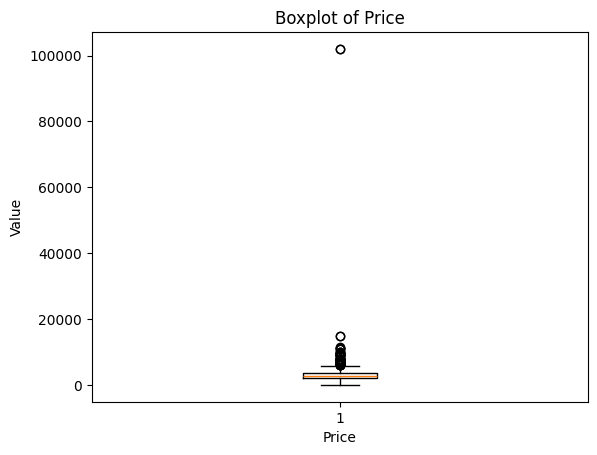

In [38]:
plt.boxplot(df_complete['Price'])
plt.xlabel('Price')
plt.ylabel('Value')
plt.title('Boxplot of Price')
plt.show()

#### Take action to outliers
From the raw data it can be seen, that we deal with a castle at this place. We think, it would be better to ignore that entry in order improve our models. 

|Feature | Value | 
|---------------- | ------ | 
|Title       |                     "For rent: SWISS BUSINESS CASTLE IN ZURICH"|
|Address       |                                                   8002 Zürich|
|Price          |                                                     102000.0|
|Rooms          |                                                           20|
|SquareMeters     |                                                        NaN|

Also when looking at the correlation matrix with the outlier and after removing it, the data brings a brouther correlation:

| Feature                   | Correlation with outlier | Correlation without outlier |
|---------------------------|-------------|-------------|
| Price                     | 1.000000    |1.000000 |
| Rooms                     | 0.601906    |0.552820 |
| SquareMeters              | 0.196403    |0.474683 |
| Etage                     | 0.050152    |0.167522 |
| Raumhöhe                  | 0.031929    |0.092157 |
| DistanceToStationKM       | 0.016078    |0.025281 |
| Anzahl Wohnungen         | -0.008176    |0.022611 |
| Anzahl Toiletten         | -0.020118    |0.018390 |
| Baujahr                  | -0.038819    |0.006123 |
| Weather                  | -0.052691    |0.029242 |
| Letztes Renovationsjahr  | -0.054533    |0.090329 |
| Longitude                | -0.073510    |0.140515 |
| Latitude                 | -0.098525    |0.228636 |

Therefore, we remove the two datapoints, with such a high value in the label:

In [39]:
# get the most expensive propertys
indices = df_complete[df_complete['Rooms'] == 20].index
print(indices)
df_complete.iloc[indices]


Index([427, 461], dtype='int64')


Price  Rooms  SquareMeters  Etage  Baujahr  Raumhöhe  \
427  102000.0   20.0          80.0    0.0   2013.0       4.0   
461  102000.0   20.0          80.0    0.0   1898.0       4.0   

     Anzahl Wohnungen  Letztes Renovationsjahr  Anzahl Toiletten  \
427                 0                   2013.0                 0   
461                 0                   1898.0                 0   

     Gasanschluss  ...  Objekttyp_Schloss  Objekttyp_Studio  \
427         False  ...               True             False   
461         False  ...               True             False   

     Objekttyp_Terrassenhaus  Objekttyp_Terrassenwohnung  Objekttyp_Villa  \
427                    False                       False            False   
461                    False                       False            False   

     Objekttyp_Wohnung   Latitude  Longitude  DistanceToStationKM  \
427              False  47.356762   8.528595             2.510193   
461              False  47.356762   8.528595             2.510193   

          Weather  
427  27918.606484  
461  27918.606484  

[2 rows x 65 columns]

In [40]:
# drop the most expensive propertys
df_complete.drop(indices, inplace=True) 
df_complete.reset_index(drop=True, inplace=True)
df_complete.shape

(983, 65)

### Correlation 
The correlation coefficient ranges from –1 to 1. 
- When it is close to 1, it means that there is a strong positive correlation. 
- When the coefficient is close to –1, it means that there is a strong negative correlation. 
- Finally, coefficients close to zero mean that there is no linear correlation.
> Géron (2017)

In [41]:
# Correlation matrix
correlation_matrix = df_complete.corr()
correlation_matrix['Price'].sort_values(ascending=False) #the correlation matrix is applied to the value Price


Price                  1.000000
SquareMeters           0.552820
Rooms                  0.474683
Tumbler                0.201643
Steamer                0.191004
                         ...   
Objekttyp_Studio      -0.098425
In Wohngemeinschaft   -0.110511
Longitude             -0.140550
Latitude              -0.228650
Objekttyp_Schloss           NaN
Name: Price, Length: 65, dtype: float64

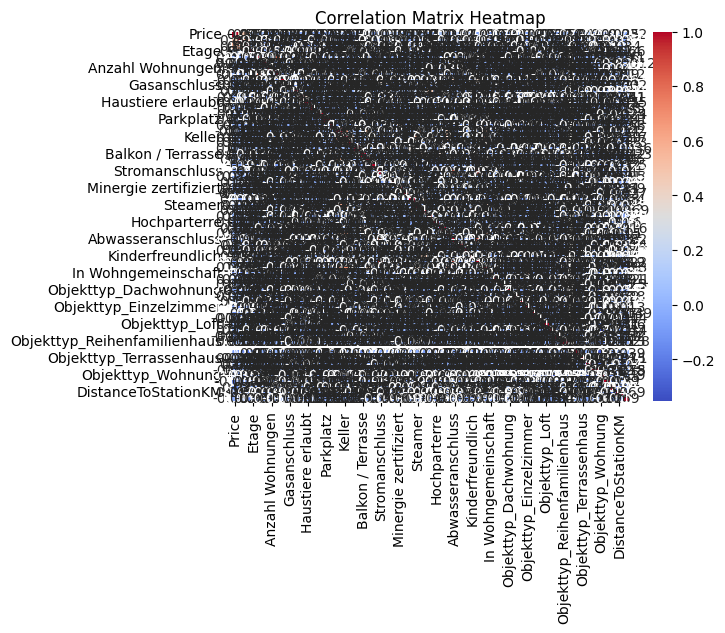

In [42]:
# create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Numeric only 
**Wait** - can we do that with the booleans? Let's try the numeric values only:

In [43]:
# generate correlation matrix
df_complete_num = df_complete.select_dtypes(include=[np.number])
df_complete_not_num = df_complete.select_dtypes(exclude=[np.number])
print('Numeric columns:', df_complete_num.shape, 'Non-numeric columns:', df_complete_not_num.shape)
correlation_matrix = df_complete_num.corr()
correlation_matrix['Price'].sort_values(ascending=False)

Numeric columns: (983, 13) Non-numeric columns: (983, 52)


Price                      1.000000
SquareMeters               0.552820
Rooms                      0.474683
Etage                      0.167522
Raumhöhe                   0.092157
DistanceToStationKM        0.025229
Letztes Renovationsjahr    0.022611
Baujahr                    0.018390
Anzahl Wohnungen          -0.006123
Anzahl Toiletten          -0.029242
Weather                   -0.032025
Longitude                 -0.140550
Latitude                  -0.228650
Name: Price, dtype: float64

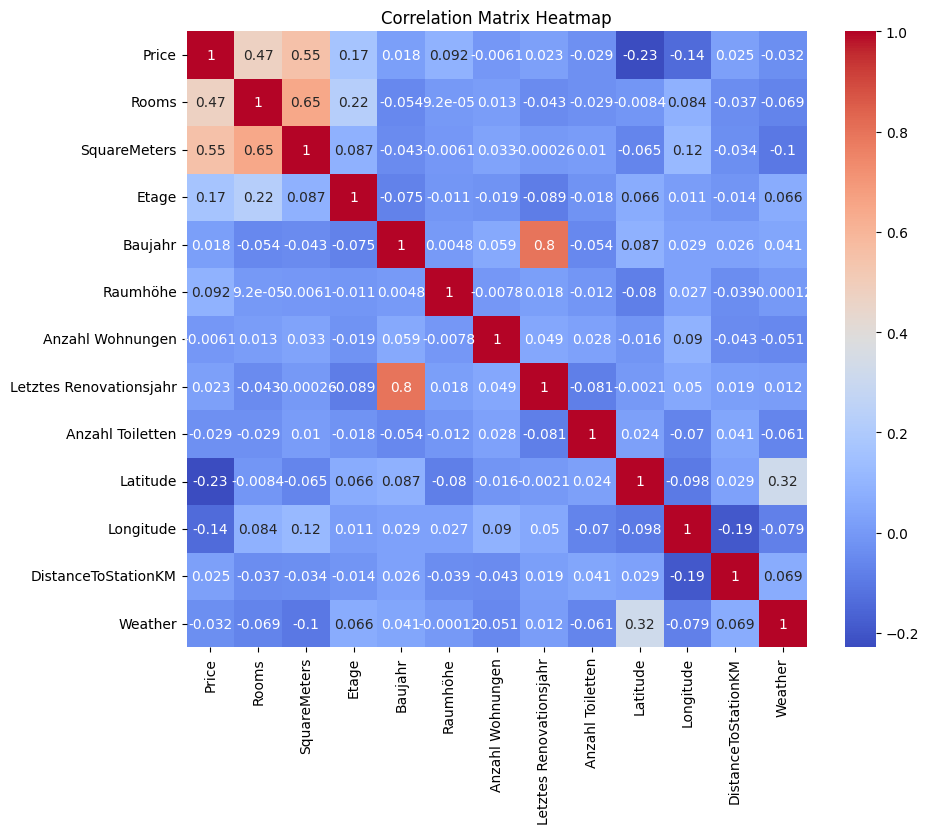

In [44]:
# create heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as per your preference
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

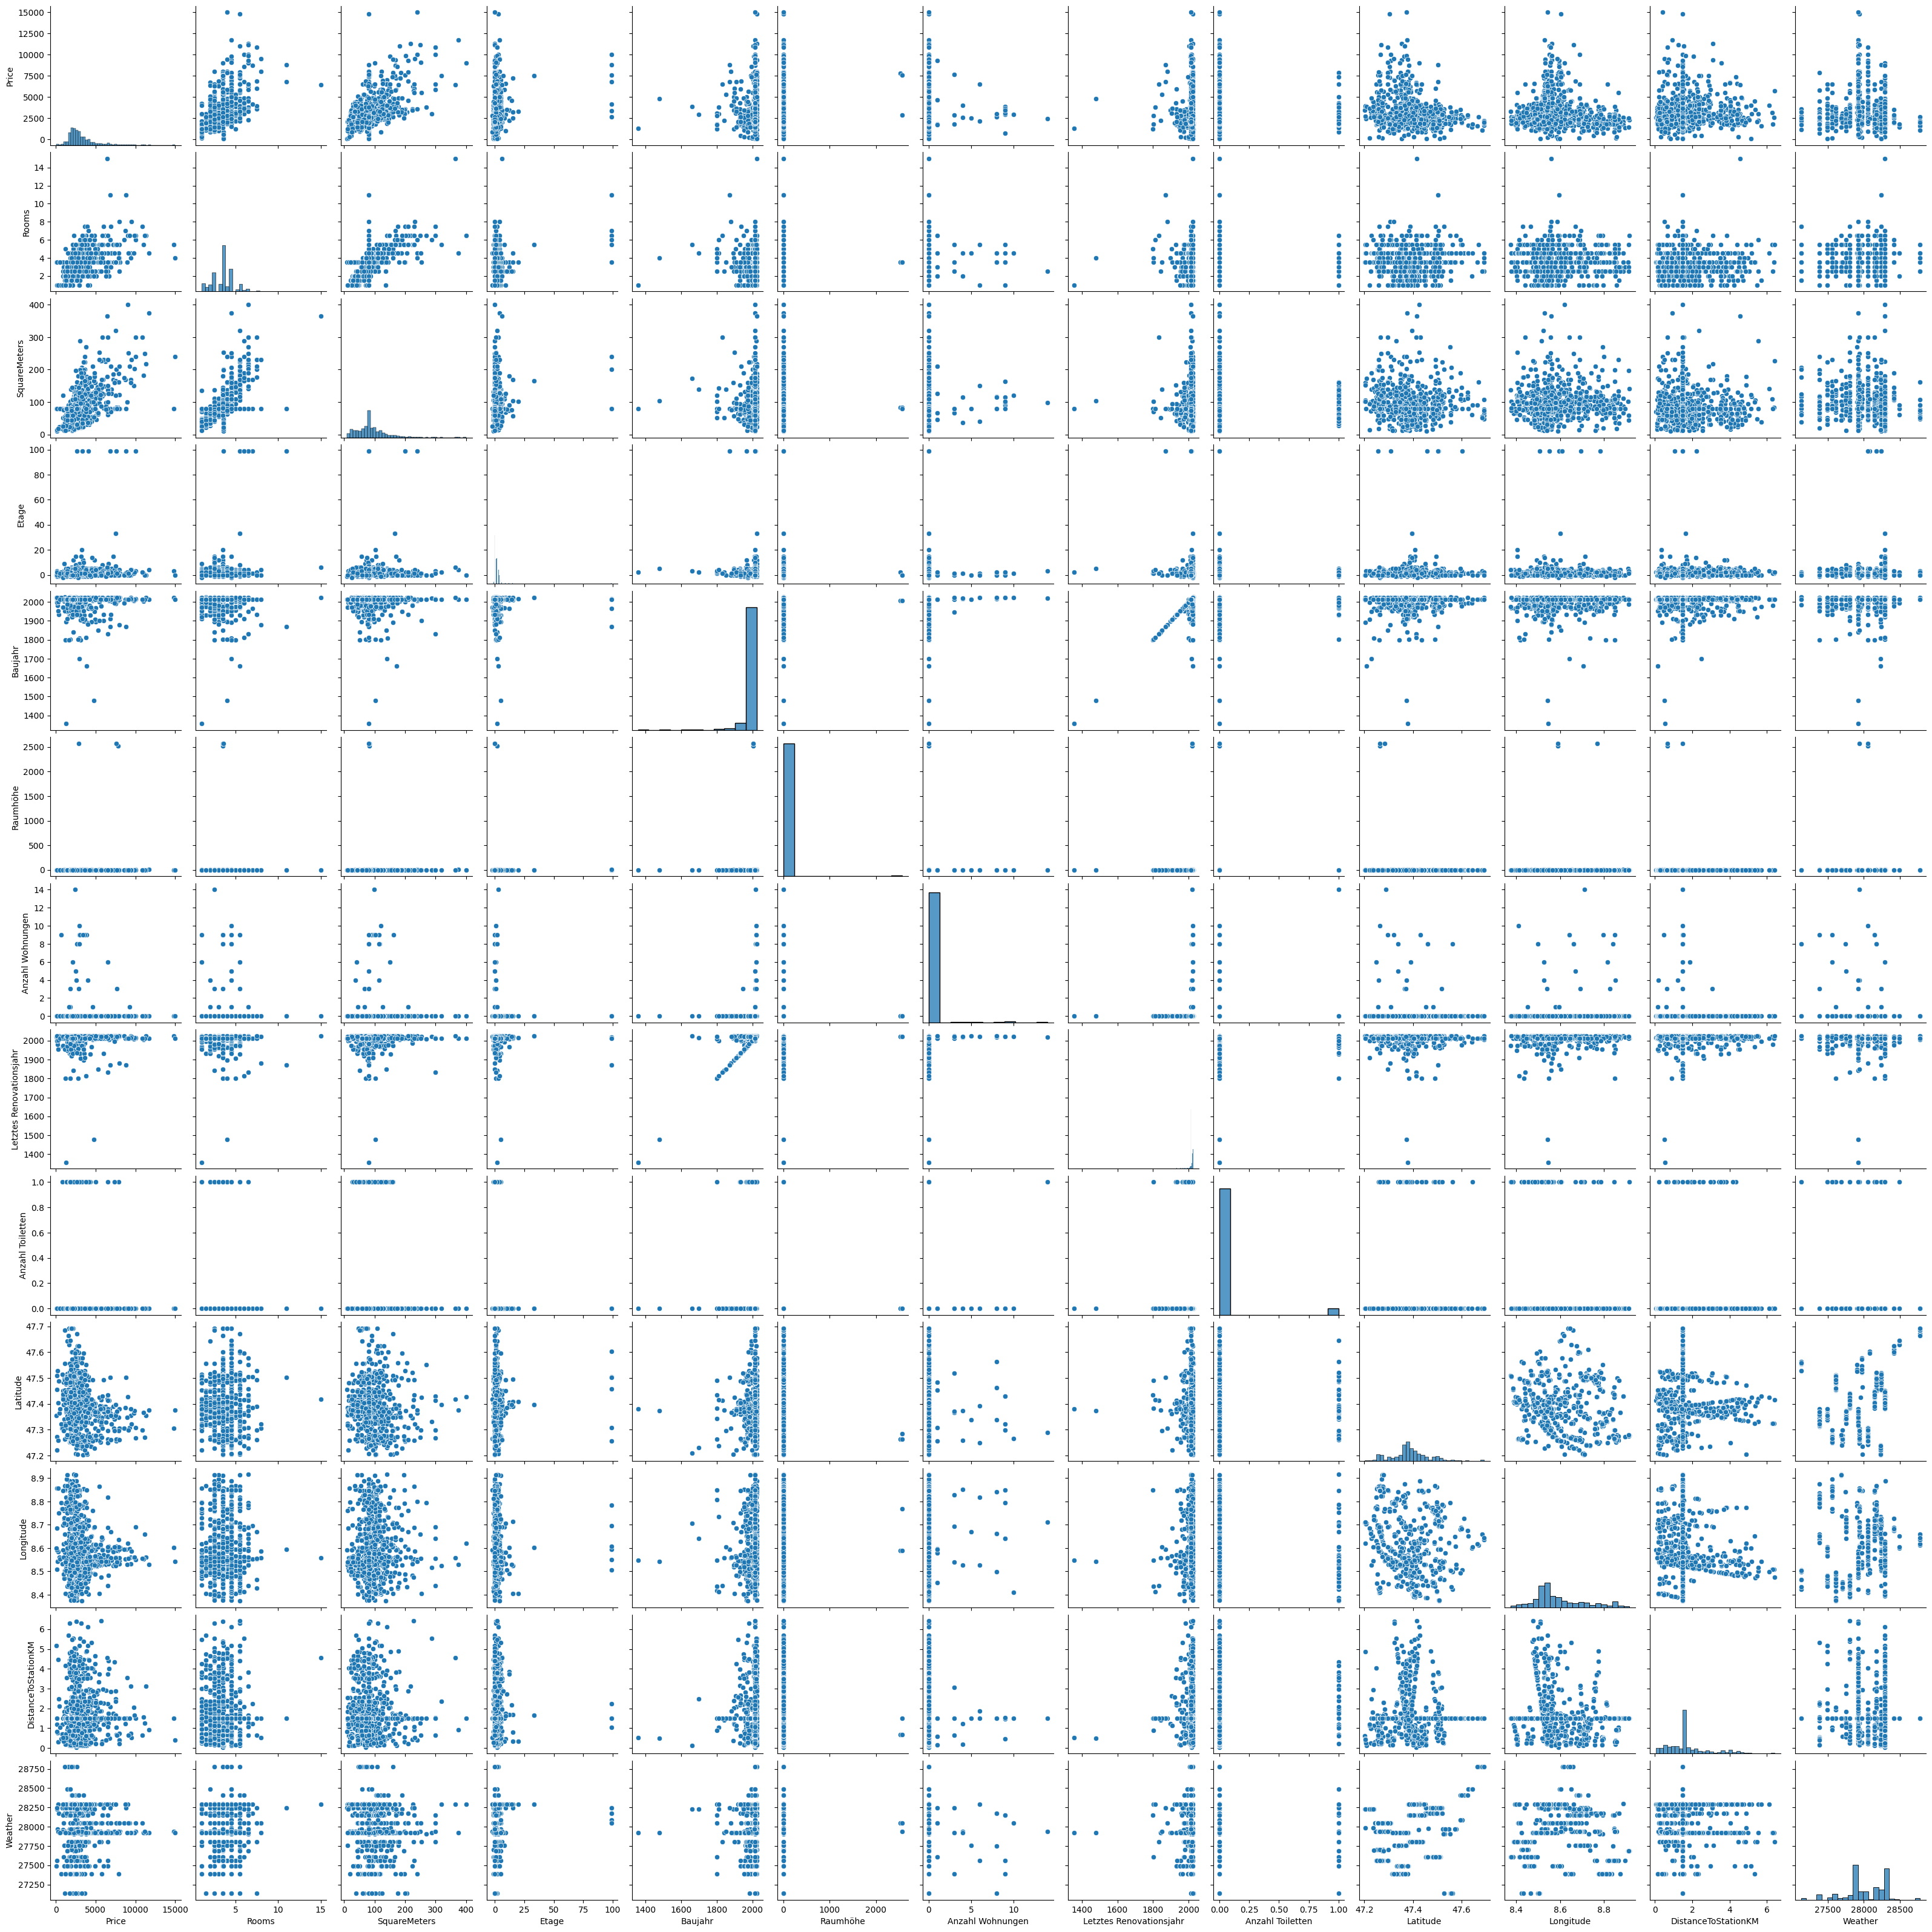

In [45]:
# Create a scatterplot matrix
sns.pairplot(df_complete_num)

# Show the plot
plt.show()

#### Interpret the correlations
A cool thing to see is that the scatter plot of Long / Lat has almost the same shape of the Canton of Zurich 😉

### Data distribution

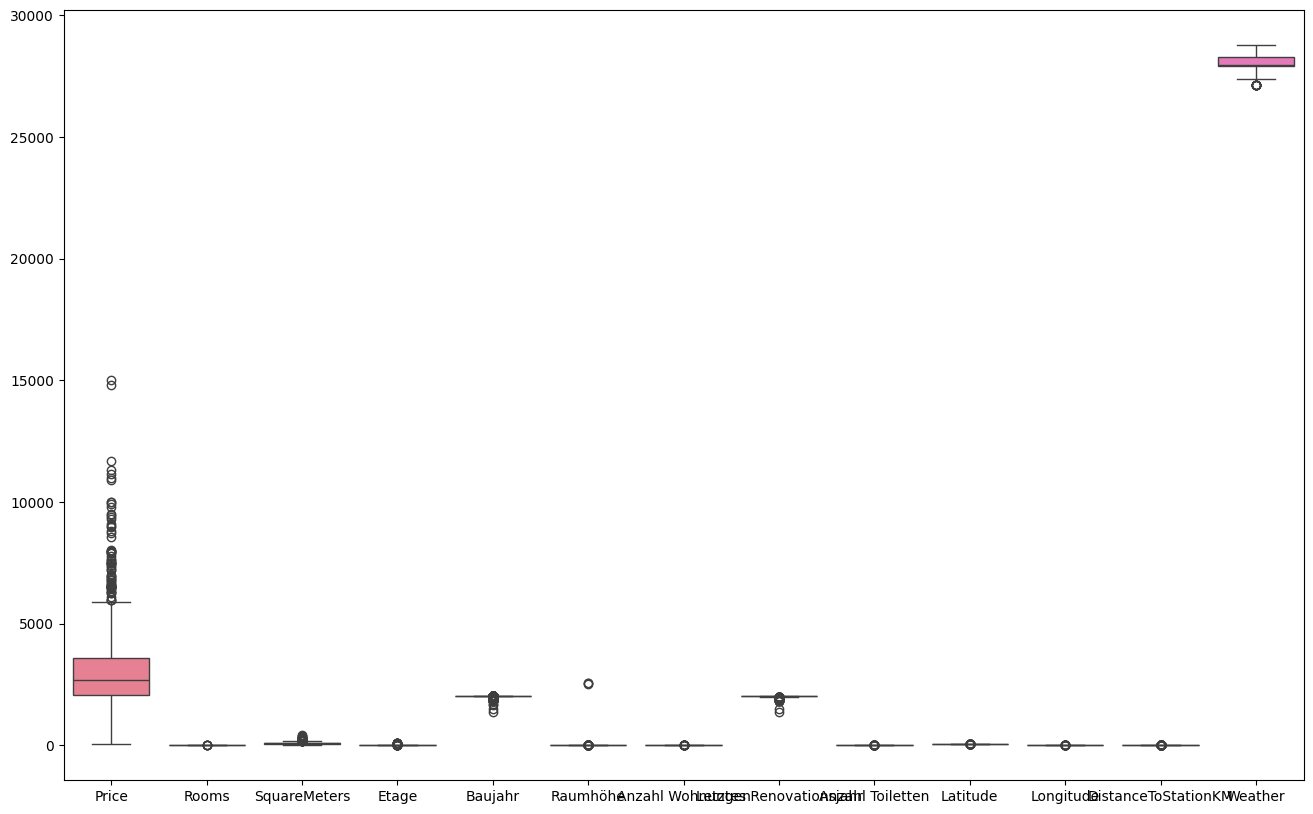

In [46]:
# Create a boxplot for each numerical feature
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_complete_num)

# Show the plot
plt.show()

## Data Preperation
### Feature Scaling 
With few exceptions, Machine Learning algorithms do not perform well when the scales of the input numerical attributes differ significantly. This is the situation with our data: the number of rooms spans from 1 to 20, and the prices range from 60.- to 102'000.-.

There are two popular ways to bring the attributes to the same scale: 
1. Min-max scaling 
    - Min-max scaling, often referred to as normalization, involves adjusting values to fall within a 0 to 1 range.
    - This scaling is achieved by subtracting the minimum value of the data and dividing by the range (max value minus min value).
    - Scikit-Learn offers a `MinMaxScaler` transformer specifically for this purpose.
    - The `MinMaxScaler` includes a `feature_range` hyperparameter that allows customization of the target range beyond the default 0 to 1.
2. Standardization
    - Standardization involves subtracting the mean and dividing by the variance to achieve zero mean and unit variance.
    - It does not limit values to a specific range, unlike min-max scaling, which may affect algorithms like neural networks because they expect a value between 0-1.
    - Standardization is less sensitive to outliers compared to min-max scaling.
    - Scikit-Learn offers a `StandardScaler` transformer for applying standardization.

> Géron (2017)

**Our decision:**
We believe that all values should ideally fall within a range between `0` and `1`. This is why we have decided to use the `MinMaxScaler.

In [47]:
# only show the numeric columns
df_complete_num.describe()

Price       Rooms  SquareMeters       Etage      Baujahr  \
count    983.000000  983.000000    983.000000  983.000000   983.000000   
mean    3145.422177    3.514615     87.459817    2.302136  2002.271617   
std     1757.016654    1.346838     49.283731    8.555394    42.942420   
min       60.000000    1.000000     10.000000   -2.000000  1357.000000   
25%     2065.500000    2.500000     58.000000    0.000000  2013.000000   
50%     2700.000000    3.500000     80.000000    1.000000  2013.000000   
75%     3600.000000    4.500000    106.000000    2.000000  2013.000000   
max    15000.000000   15.000000    400.000000   99.000000  2025.000000   

          Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  \
count   983.000000        983.000000               983.000000   
mean     10.288454          0.158698              2009.458800   
std     140.981993          1.122462                35.869532   
min       0.000000          0.000000              1357.000000   
25%       2.500000          0.000000              2013.000000   
50%       2.500000          0.000000              2013.000000   
75%       2.500000          0.000000              2022.000000   
max    2572.000000         14.000000              2025.000000   

       Anzahl Toiletten    Latitude   Longitude  DistanceToStationKM  \
count        983.000000  983.000000  983.000000           983.000000   
mean           0.047813   47.389965    8.593067             1.767667   
std            0.213479    0.082574    0.115353             1.182859   
min            0.000000   47.202984    8.373245             0.041289   
25%            0.000000   47.352562    8.525744             1.061881   
50%            0.000000   47.381815    8.551597             1.491088   
75%            0.000000   47.429681    8.654698             2.115728   
max            1.000000   47.692142    8.915707             6.424753   

            Weather  
count    983.000000  
mean   28015.090530  
std      275.188711  
min    27135.424313  
25%    27918.606484  
50%    27968.336456  
75%    28288.062473  
max    28774.213407

In [48]:
# Scale the numerical features
df_complete_num_scaled = pd.DataFrame(minmax_scale(df_complete_num), columns=df_complete_num.columns)
df_complete_num_scaled.describe() 

Price       Rooms  SquareMeters       Etage     Baujahr  \
count  983.000000  983.000000    983.000000  983.000000  983.000000   
mean     0.206521    0.179615      0.198615    0.042595    0.965975   
std      0.117605    0.096203      0.126369    0.084707    0.064285   
min      0.000000    0.000000      0.000000    0.000000    0.000000   
25%      0.134237    0.107143      0.123077    0.019802    0.982036   
50%      0.176707    0.178571      0.179487    0.029703    0.982036   
75%      0.236948    0.250000      0.246154    0.039604    0.982036   
max      1.000000    1.000000      1.000000    1.000000    1.000000   

         Raumhöhe  Anzahl Wohnungen  Letztes Renovationsjahr  \
count  983.000000        983.000000               983.000000   
mean     0.004000          0.011336                 0.976735   
std      0.054814          0.080176                 0.053697   
min      0.000000          0.000000                 0.000000   
25%      0.000972          0.000000                 0.982036   
50%      0.000972          0.000000                 0.982036   
75%      0.000972          0.000000                 0.995509   
max      1.000000          1.000000                 1.000000   

       Anzahl Toiletten    Latitude   Longitude  DistanceToStationKM  \
count        983.000000  983.000000  983.000000           983.000000   
mean           0.047813    0.382250    0.405229             0.270445   
std            0.213479    0.168809    0.212648             0.185301   
min            0.000000    0.000000    0.000000             0.000000   
25%            0.000000    0.305786    0.281125             0.159881   
50%            0.000000    0.365589    0.328782             0.227118   
75%            0.000000    0.463443    0.518845             0.324971   
max            1.000000    1.000000    1.000000             1.000000   

          Weather  
count  983.000000  
mean     0.536778  
std      0.167922  
min      0.000000  
25%      0.477903  
50%      0.508249  
75%      0.703347  
max      1.000000

#### Visualization of scaled data distribution
Now it makes more sense to look at the boxplots than before.

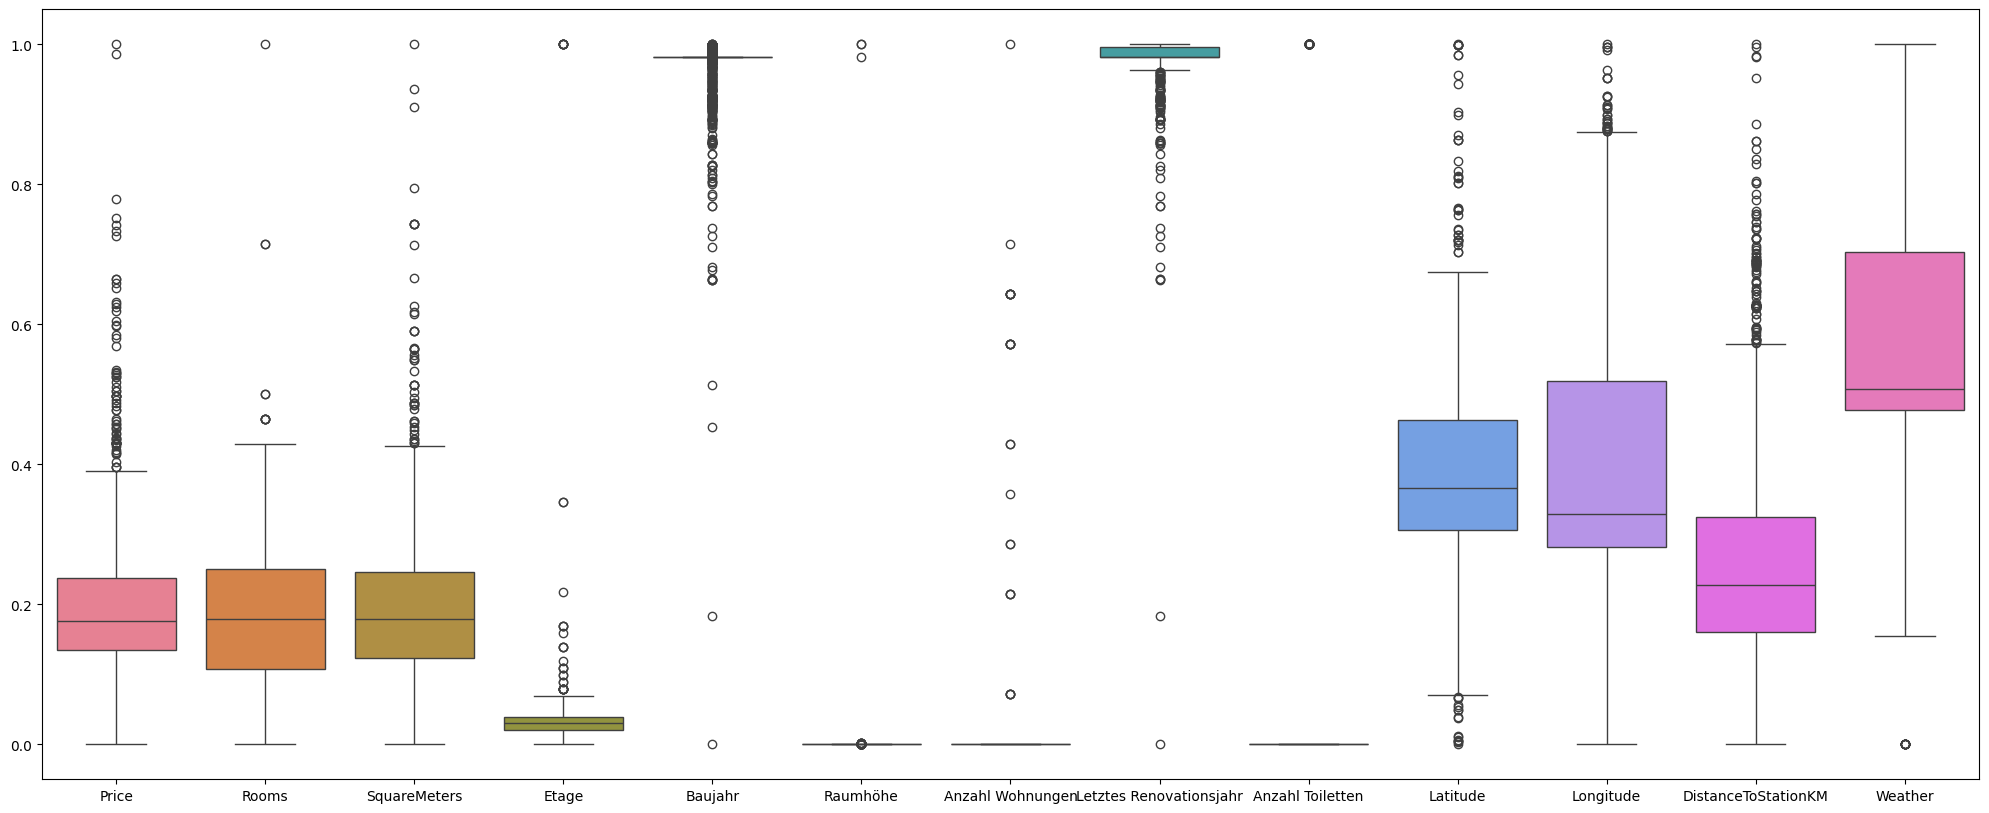

In [49]:
# Create a boxplot for each numerical feature
plt.figure(figsize=(25, 10))
sns.boxplot(data=df_complete_num_scaled)

# Show the plot
plt.show()

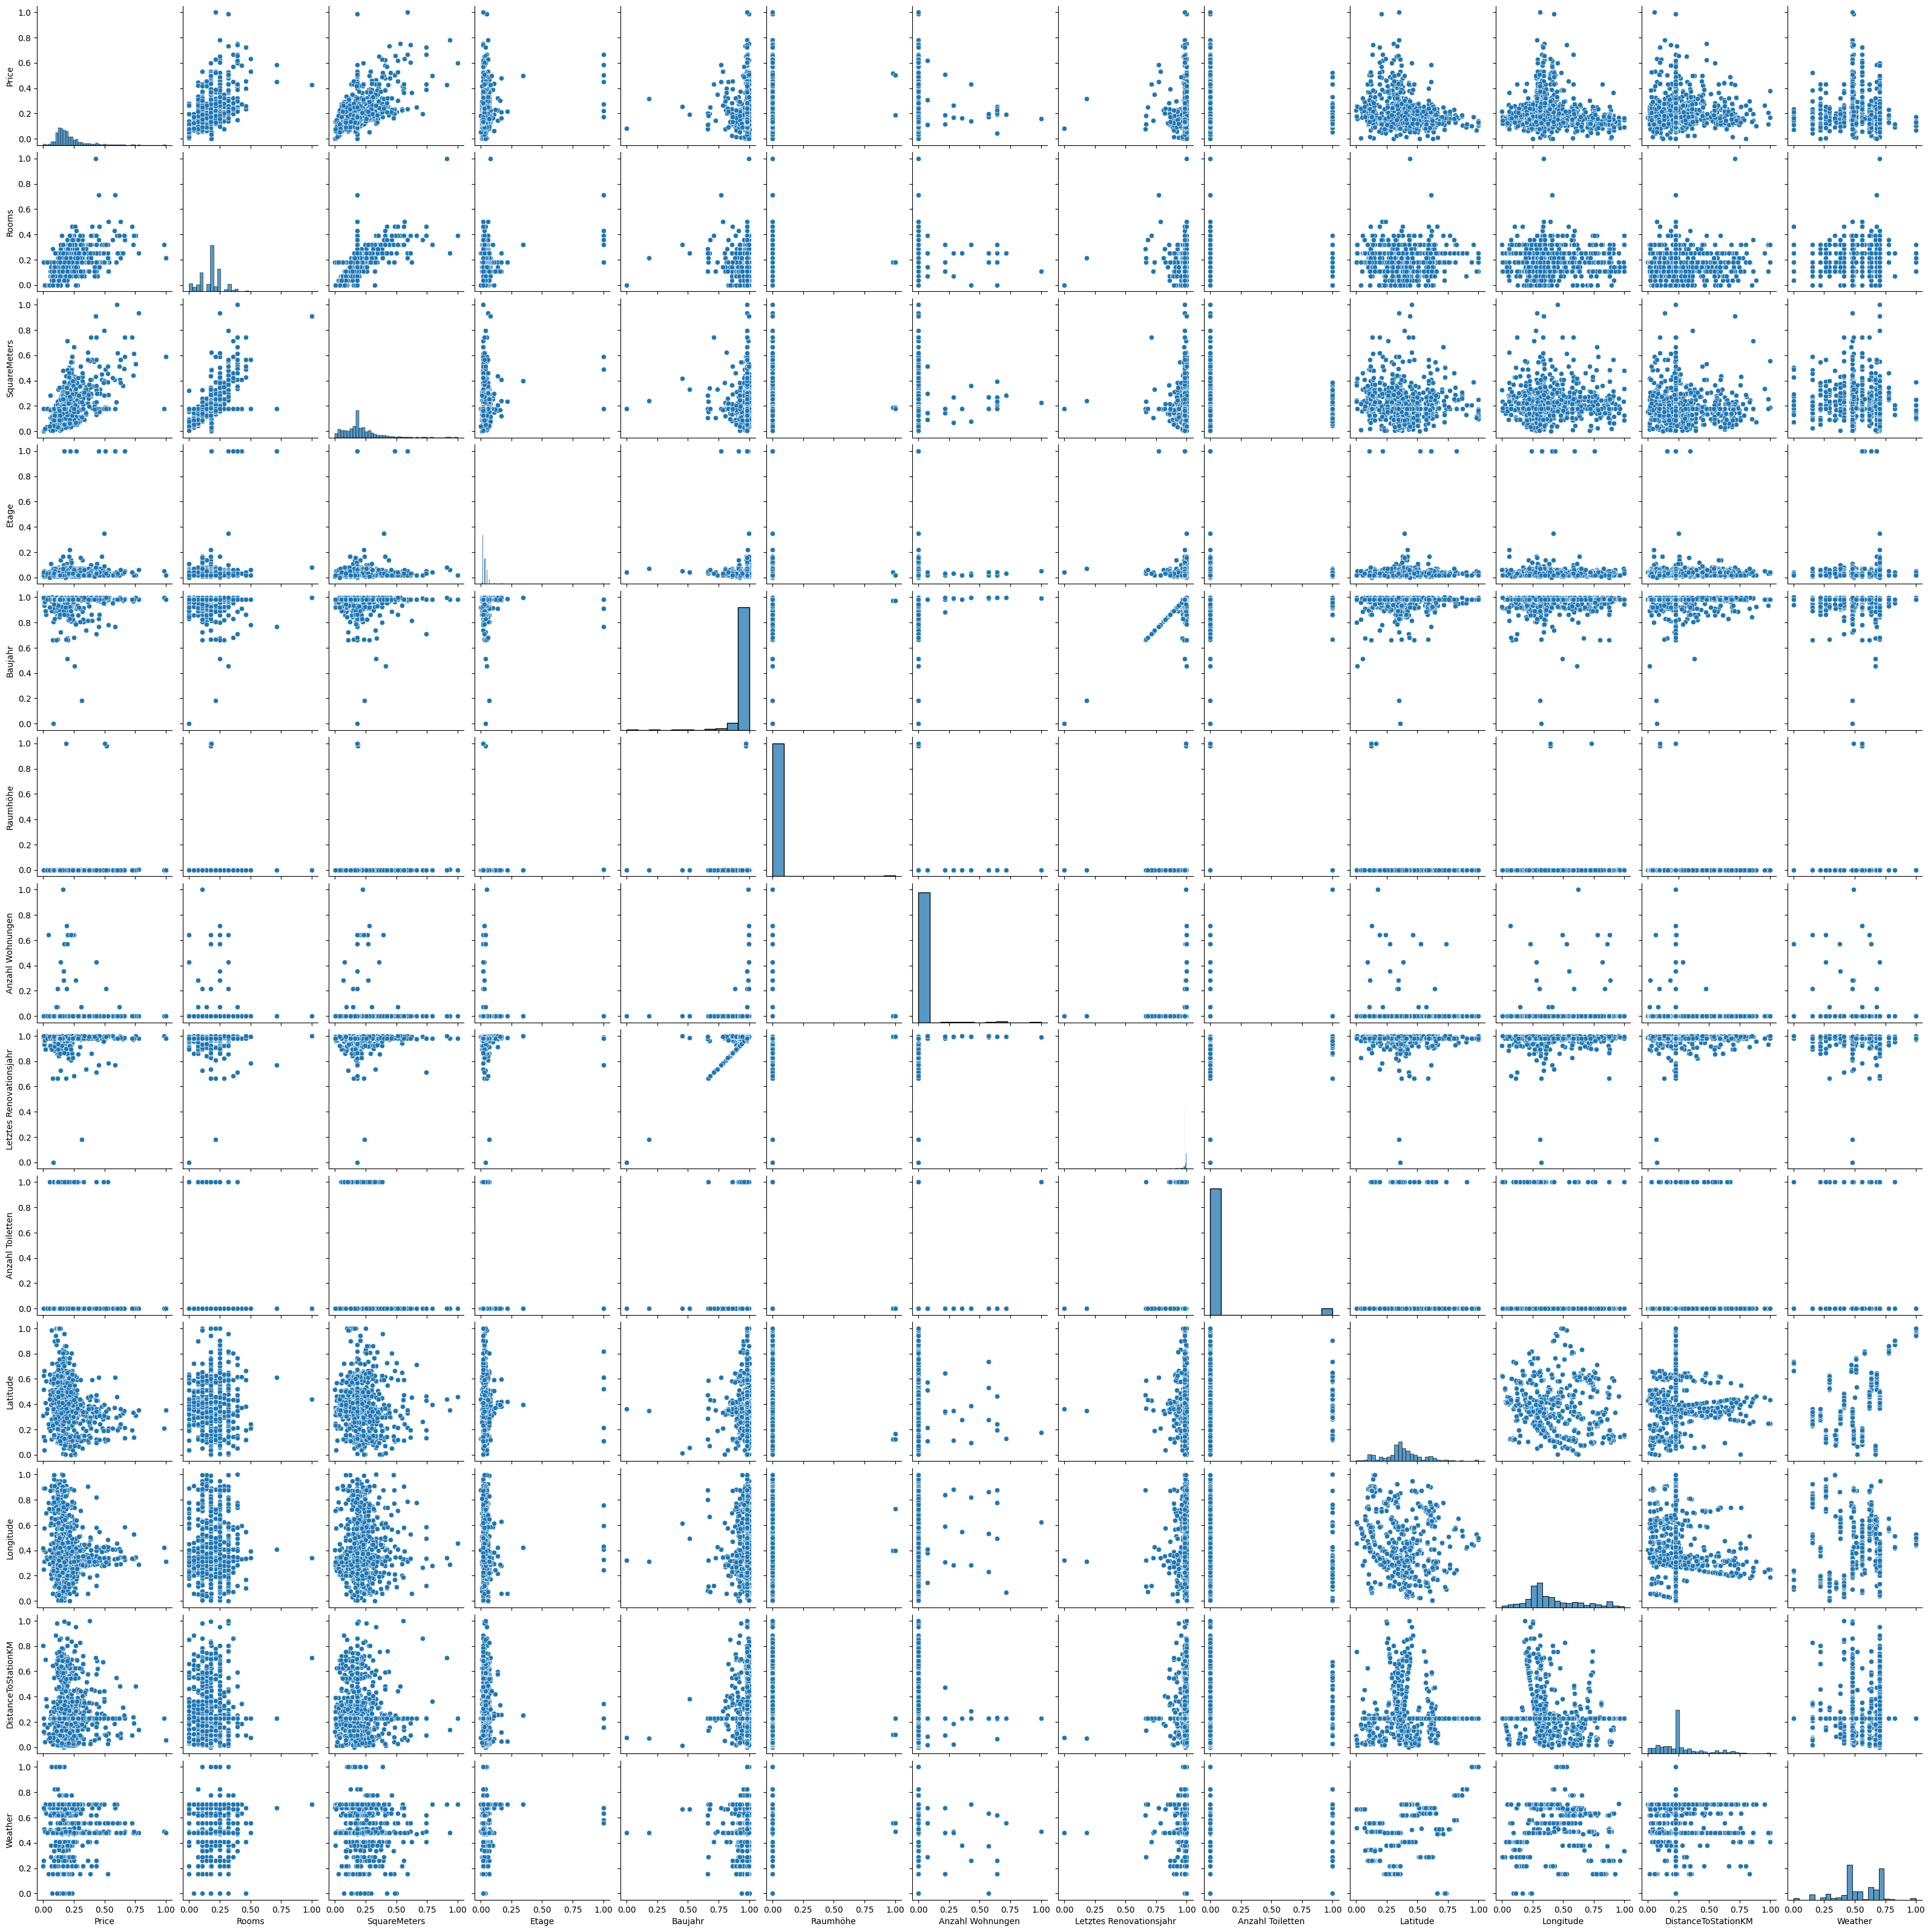

In [50]:
# Create a scatterplot matrix
sns.pairplot(df_complete_num_scaled)

# Show the plot
plt.show()

In [51]:
#redo the correlation matrix
correlation_matrix_scaled = df_complete_num_scaled.corr()
correlation_matrix_scaled['Price'].sort_values(ascending=False)

Price                      1.000000
SquareMeters               0.552820
Rooms                      0.474683
Etage                      0.167522
Raumhöhe                   0.092157
DistanceToStationKM        0.025229
Letztes Renovationsjahr    0.022611
Baujahr                    0.018390
Anzahl Wohnungen          -0.006123
Anzahl Toiletten          -0.029242
Weather                   -0.032025
Longitude                 -0.140550
Latitude                  -0.228650
Name: Price, dtype: float64

In [52]:
# show the shape of numeric and non-numeric columns
print('Numeric columns:', df_complete_num_scaled.shape, 'Non-numeric columns:', df_complete_not_num.shape)

Numeric columns: (983, 13) Non-numeric columns: (983, 52)


In [53]:
# Concatenate the scaled numerical features with the non-numeric features
df_complete_scaled = pd.concat([df_complete_num_scaled, df_complete_not_num], axis=1, ignore_index= False)
df_complete_scaled.shape

(983, 65)

In [54]:
# Save the final DataFrame to a new CSV file
df_complete_scaled.to_csv('data/immoscout24_zh_complete_scaled.csv', index=False, sep=';')

### Data Seperation

Before starting modeling we have to prepear the dataset accordingly. We have to split into train and test set. However for most of the models it is needed that label (y) and features (X) are separated as well. 


- Split X/y (Feature and Label)
    - `X_train = train_data.loc[:,train_data.columns != "Price"]`
- Train/Test Split
    - 70/30

#### Feature / Label Split

In [124]:
# Load the final DataFrame
df_complete_scaled = pd.read_csv('data/immoscout24_zh_complete_scaled.csv', sep=';')
print(df_complete_scaled.shape)
X = df_complete_scaled.drop(columns=['Price'])
y = df_complete_scaled['Price']
X.shape, y.shape

(983, 65)


((983, 64), (983,))

In [125]:
# make sure about nan values
df_complete_scaled.isna().sum()

Price                              0
Rooms                              0
SquareMeters                       0
Etage                              0
Baujahr                            0
Raumhöhe                           0
Anzahl Wohnungen                   0
Letztes Renovationsjahr            0
Anzahl Toiletten                   0
Latitude                           0
Longitude                          0
DistanceToStationKM                0
Weather                            0
Gasanschluss                       0
Waschmaschine                      0
Kabel-TV                           0
Haustiere erlaubt                  0
Gedeckt                            0
Mit Gartenhaus                     0
Parkplatz                          0
Minergie Bauweise                  0
Tumbler                            0
Keller                             0
Estrich                            0
Rollstuhlgängig                    0
Balkon / Terrasse                  0
Spielplatz                         0
A

#### Train / Test Split

In [126]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((786, 64), (786,))

In [127]:
# present the data shape
X_test.shape, y_test.shape

((197, 64), (197,))

## Model Building
### Choose Model(s)
For our regression problem, we will evaluate and compare the following models to find the best fit for predicting house prices. The models include both linear and non-linear approaches to accommodate different patterns and complexities in the data.

#### Models to Evaluate
**1. Linear Regression**
   - A simple yet powerful model that assumes a linear relationship between input variables and the target. It's effective when the relationship is linear and is easy to interpret.
   - Import with: `from sklearn.linear_model import LinearRegression`    
   <img src="resources\linear-regression.png" width="400">
   <br><small>[Image Source](https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2), Retrieved March 29, 2024</small>

**2. Decision Tree**
   - Is a model that represents data through a series of decisions made from the features of the data, organized as branches on a tree. Each branch represents a choice between possible options, leading to different outcomes or predictions. This model is effective for both classification and regression tasks and is capable of handling non-linear data. It can easily manage varied data types and is interpretable, as the decisions taken by the model can be traced clearly through the tree.
   - Import with: `from sklearn.tree import DecisionTreeRegressor`
   <br><img src="resources\Regression-decision-tree.png" width="400">
   <br><small>[Image Source](https://www.researchgate.net/figure/Fig-A11-Regression-decision-tree-the-ensemble-model-representing-the-training-stage_fig4_313489088), Retrieved May 07, 2024</small>

**3. Random Forest Regressor**
   - Is an ensemble learning model that operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees. This approach helps in reducing overfitting and increasing the prediction accuracy, particularly with complex and nonlinear data sets. The model is robust against outliers and is effective in handling various types of data features, making it versatile across different regression tasks. Additionally, its ensemble nature helps in capturing a more comprehensive range of patterns in the data, leading to more reliable predictions.
   - Import with: `from sklearn.ensemble import RandomForestRegressor`
   <br><img src="resources\Random-Forest-Regressor.png" width="400">
   <br><small>[Image Source](https://www.researchgate.net/figure/Fig-A10-Random-Forest-Regressor-The-regressor-used-here-is-formed-of-100-trees-and-the_fig3_313489088), Retrieved March 29, 2024</small>

**4. Neural Network (NN) Model using TensorFlow**
   - A highly flexible and powerful model capable of modeling complex non-linear relationships. Neural networks are particularly useful when we have a large amount of data and the relationship between variables is complex.
   - Implemented using TensorFlow, which provides the tools to build custom neural network architectures.
   <br><img src="resources\nn.png" width="400">
   <br><small>[Image Source](https://medium.com/deepviz/explainable-ai-and-visual-interpretability-dawn-of-neural-networks-part-5-b302e7d85650), Retrieved March 29, 2024</small>


In order to evaluate the models, we look at **Performance Metrics**. We asses the models using regression-specific metrics including:
  - RMSE (Root Mean Square Error): Measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s particularly useful to compare prediction errors of different models and datasets.
  - MAE (Mean Absolute Error): Provides a measure of errors between paired observations expressing the same phenomenon.
  - R² (Coefficient of Determination): Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

### Train Model
Each model will be trained using the same set of training data. This allows for a fair comparison between models based on their performance metrics.

- **Data Split**: Split the data into training and validation sets to evaluate the model's performance.
- **Training Process**: Fit each model to the training data using their respective training algorithms.

#### Linear Regression

In [128]:
# Linear Regression

# Create a Linear Regression model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
lr_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
lr_rmse = np.sqrt(lr_mse)

# Calculate the R-squared value
lr_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {lr_mse:.2f}, Root Mean Squared Error: {lr_rmse:.2f}, R-squared: {lr_r2:.2f}')

Mean Squared Error: 0.01, Root Mean Squared Error: 0.08, R-squared: 0.51


Not too bad! A good model will have a low MSE and RMSE and a high R-squared value.

---
#### Decision Tree

In [129]:
# Decision Tree Regressor / Random Forest Regressor

# Create a Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
dt_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
dt_rmse = np.sqrt(dt_mse)

# Calculate the R-squared value
dt_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {dt_mse:.2f}, Root Mean Squared Error: {dt_rmse:.2f}, R-squared: {dt_r2:.2f}')


Mean Squared Error: 0.01, Root Mean Squared Error: 0.08, R-squared: 0.50


A bit lower than Linear Regressor. What if we add some complexity in the next step?

---
#### Random Forest Regressor

In [130]:

# Create a Random Forest Regressor model
rfr_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rfr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rfr_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rfr_rmse = np.sqrt(rfr_mse)

# Calculate the R-squared value
rfr_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {rfr_mse:.2f}, Root Mean Squared Error: {rfr_rmse:.2f}, R²: {rfr_r2:.2f}')

Mean Squared Error: 0.00, Root Mean Squared Error: 0.06, R²: 0.74


Highest R-squared so far. Let's try a fancy Regression with a NN.

---
#### Zusatzpunkte (4) Verwendung einer fortgeschrittenen Deep Learning Struktur/Technik
Since we deal with structured data (nor image data, nor time-series data) and a regression problem a more traditional approach like a dense neural network or even tree-based models may actually perform better for prediction.

##### NLP - Natural language processing
We try also to apply NLP for the use case of house price prediction. Use the [notebook **here**](openai.ipynb) to see how we dealed with the OpenAI API to load the data to the NLP model.

📊 We are using natural language processing techniques to analyze textual data related to house descriptions and other relevant information to predict house prices more accurately. 

📁 The clean data is crucial as it ensures the reliability and accuracy of our predictive model. We will extract and preprocess textual data to create features that can be used in our machine learning models. 

##### Neural Network Regressor 
Also, for the sake of the additional points we try to apply the MLP can be quite effective. Multi-Layer Perceptron is an artificial neural network that is widely used in machine learning research and in the field of supervised learning. It consists of at least three layers of neurons: an input layer, one or more hidden layers, and an output layer.

We will use Keras to build a simple neural network. There are some choices that have to be done regarding the model parameters:
1. Input Layer: The size (128 neurons) is chosen to be sufficiently large to capture the complexity from 65 input features. However, we do not want to choose a too large input layer sice on order to avoid overfitting.
2. Hidden Layers: We choose two additional hidden layers with decreasing sizes (64 and 32 neurons) to create a funnel-like structure, which is helping the network to learn more abstract representations in a hierarchical manner.
3. Activation Function: The choice is the relu-function (Rectified Linear Unit). It is used because it performs well in avoiding the vanishing gradient problem and shal be effective in regression tasks.
4. Output Layer: The output layer has a single neuron, as it's a regression task (predicting a continuous value). The default linear activation function (None) is appropriate here.
5. Optimizer: 'Adam' is chosen as it's an effective and popular choice for many types of neural networks. It adjusts the learning rate during training.
6. Loss Function: 'MSE' (Mean Squared Error) is used for regression problems as it effectively captures the average squared difference between the predicted and actual values.

In [131]:
# Neural Network Regressor

# Initialize the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(64,)),  # Input layer with 65 features and ReLU activation
    Dense(110, activation='relu'),                      # Hidden layer with 64 neurons
    Dense(32, activation='relu'),                      # Further condensed hidden layer
    Dense(1)                                           # Output layer with 1 neuron for regression
])

model.compile(
    optimizer='Adam',            # Efficient optimization algorithm
    loss='mse',                  # Mean Squared Error for regression
    metrics=['mae']              # Mean Absolute Error for performance monitoring
)

# our first NN with which we achieved the best r^2 value so far

In [132]:
# Create a Sequential model
model = Sequential()

# Add the input layer and the first hidden layer with dropout and with 65 features and ReLU activation
model.add(Dense(512, activation='relu', input_shape=(64,)))
model.add(Dropout(0.5))

# Add a second hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Add a third more condensed hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add a fourth hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer
model.add(Dense(1))

# Compile the model
model.compile(
    optimizer=RMSprop(learning_rate=0.001),  
    loss='mse',                           # Mean Squared Error for regression
    metrics=['mae']                       # Mean Absolute Error for performance monitoring
)

In [133]:
history = model.fit(X_train.astype(float), y_train.astype(float), epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
20/20 [==============================] - 1s 22ms/step - loss: 0.0666 - mae: 0.1869 - val_loss: 0.0341 - val_mae: 0.1442
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0335 - mae: 0.1361 - val_loss: 0.0324 - val_mae: 0.1396
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0243 - mae: 0.1144 - val_loss: 0.0262 - val_mae: 0.1179
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0211 - mae: 0.1042 - val_loss: 0.0221 - val_mae: 0.1033
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0180 - mae: 0.0953 - val_loss: 0.0223 - val_mae: 0.1041
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0184 - mae: 0.0925 - val_loss: 0.0212 - val_mae: 0.0998
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0165 - mae: 0.0884 - val_loss: 0.0195 - val_mae: 0.0927
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0173 - 

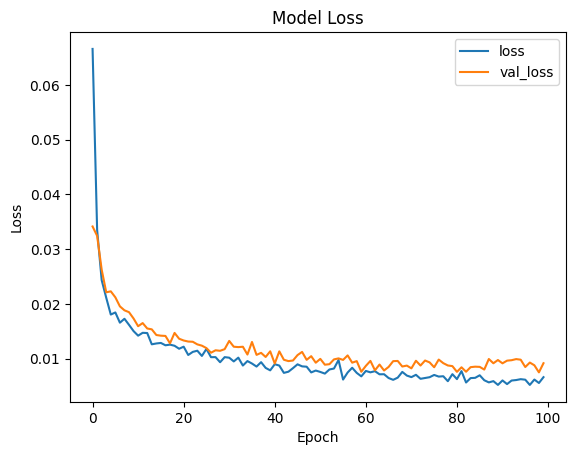

In [134]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [135]:
loss, mae = model.evaluate(X_test.astype(float), y_test.astype(float))
print(f"Test Loss: {loss}, Test MAE: {mae}")

7/7 [==============================] - 0s 2ms/step - loss: 0.0113 - mae: 0.0668
Test Loss: 0.011309307999908924, Test MAE: 0.06679203361272812


In [136]:
# Make predictions on the test data
y_pred = model.predict(X_test.astype(float))

# Calculate the Mean Squared Error (MSE)
nn_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
nn_rmse = np.sqrt(nn_mse)

# Calculate the R-squared value
nn_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {nn_mse:.2f}, Root Mean Squared Error: {nn_rmse:.2f}, R-squared: {nn_r2:.2f}')

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 0.01, Root Mean Squared Error: 0.11, R-squared: 0.20


### Model Evaluation
Evaluate the performance of each model using the following plot:




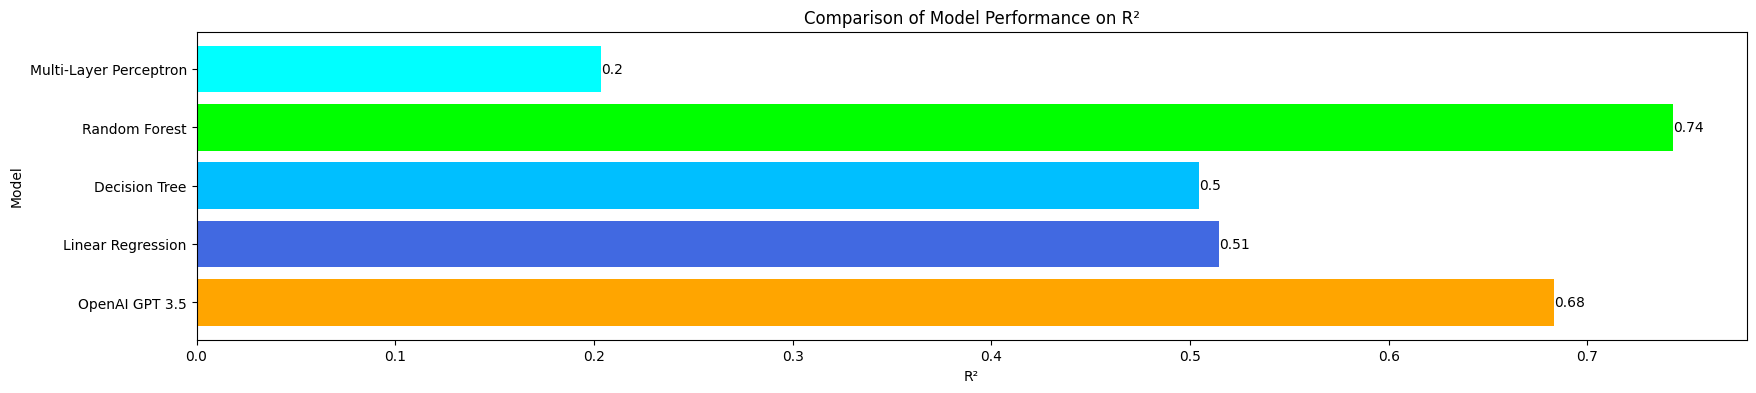

In [137]:
# This is the r^2 value of the Large Language model try in the openai.ipynb file
llm_r2 = 0.6834336633716507
# Comparison of Model Performance on R² in a plot
plt.figure(figsize=(20, 4))
plt.barh(["OpenAI GPT 3.5", 'Linear Regression', 'Decision Tree', 'Random Forest', "Multi-Layer Perceptron"], [llm_r2, lr_r2, dt_r2, rfr_r2, nn_r2], color=['orange', 'royalblue', 'deepskyblue', 'lime', 'cyan'])
plt.xlabel('R²')
plt.ylabel('Model')
plt.title('Comparison of Model Performance on R²')

# Add the values to the plot
for i, v in enumerate([llm_r2, lr_r2, dt_r2, rfr_r2, nn_r2]):
    plt.text(v, i, str(round(v, 2)), color='black', va='center')

plt.show()


#### Model Selection
The Random Forest Regression model demonstrated superior performance in terms of the R² value compared to the other models. Consequently, we determined that we will take this model to do improvements on it in the next steps:

#### Model Visaulisation 
To see how the selected model "Random Forest Regression" looks like, let's have a look at the tree.


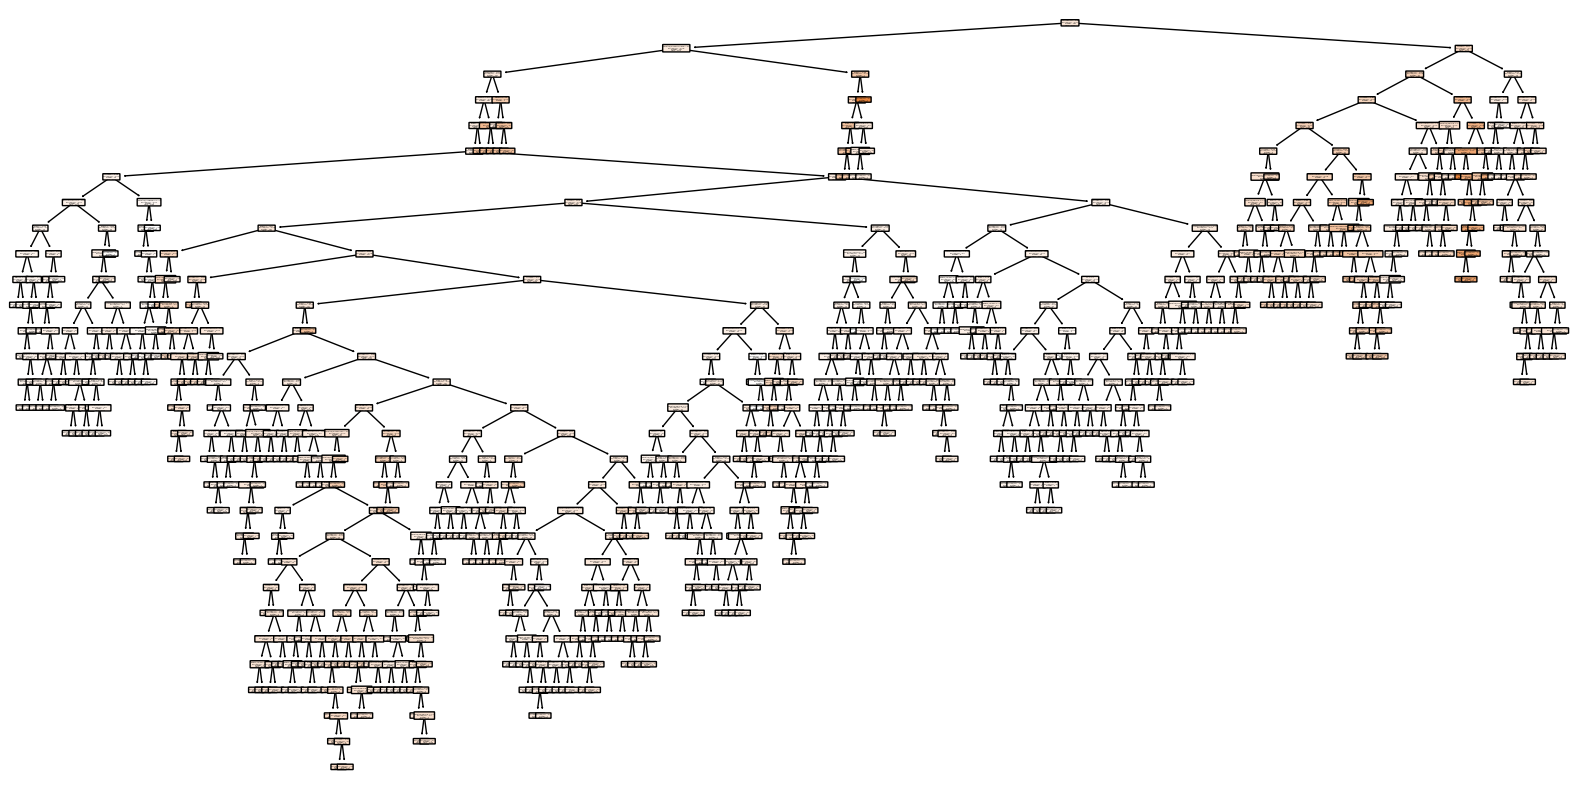

In [72]:
# Get the first decision tree from the random forest
first_tree = rfr_model.estimators_[0]

plt.figure(figsize=(20,10))  # Set the figure size
plot_tree(first_tree, filled=True, feature_names=X_train.columns, rounded=True)
plt.show()

### Fine-Tune the Model
We now need to fine-tune the model. One way to do that would be to manually fiddle with the hyperparameters until we find a great  combination of hyperparameter values. However, this would be very tedious work. Instead we apply **Grid Search**. 

We look at the following parameters for improvement:
1. `n_estimators` (Number of Trees):
    - Increasing the number of trees can often improve the model's performance because it makes the model's predictions more stable and robust, though at the cost of increased computational resources.
2. `max_features` (Number of Features for Splitting):
    - The default Value 1.0 is meaning each split considers all features.
    - Adjusting this parameter to a lower value such as 'sqrt' (square root of the total number of features) or 'log2' can help with increasing model diversity. Hence it is reducing the correlation between the trees.
3. `max_depth` (Maximum Depth of Each Tree):
    - `None` allows trees to grow until all leaves are pure or until all leaves contain less than min_samples_split samples. This might cause the trees to overfit. Setting a max depth (e.g., 10, 20, or 30) might help prevent overfitting by adding constraints to the size of the tree.
4. `min_samples_split`: 
    - Increasing this value requires more samples to create a new node, which can lead to a model that generalizes better.
5. `min_samples_leaf`:
    - Increasing this number means a leaf node must have more samples, which also helps in controlling overfitting.
6. `bootstrap`:
    - Bootstrap helps to helps provied a better estimate of the population distribution.
    - It is recomendet to set it to ``True``
7. `ccp_alpha`:
    - A larger value of ``ccp_alpha`` will prune more aggressively, which can help in reducing the complexity.


In [73]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [1.0, 'auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Create a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best R^2 score:", grid_search.best_score_, "\nwith the following parameters:")
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits


Best R^2 score: 0.6647564762606951 
with the following parameters:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': None,
 'max_features': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [114]:
# Create a new Random Forest Regressor model with the best parameters
model = RandomForestRegressor(**best_params, random_state=42) # ** in Python are used for unpacking a dictionary

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rfrgrid_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rfrgrid_rmse = np.sqrt(rfrgrid_mse)

# Calculate the R-squared value
rfrgrid_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {rfrgrid_mse:.2f}, Root Mean Squared Error: {rfrgrid_rmse:.2f}, R²: {rfrgrid_r2:.2f}')

Mean Squared Error: 0.00, Root Mean Squared Error: 0.06, R²: 0.71


#### Interpretation of Grid Search 
**Hold on** - This is a lower value than in the first shot. What was the Value in R² there again. And even more interessting, what were the parameters there? 

In [144]:
# Create a Random Forest Regressor model
rfr_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rfr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rfr_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rfr_rmse = np.sqrt(rfr_mse)

# Calculate the R-squared value
rfr_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {rfr_mse:.2f}, Root Mean Squared Error: {rfr_rmse:.2f}, R²: {rfr_r2:.2f}')

# Get the parameters of the trained model
model_params = rfr_model.get_params()

# Print the parameters
for param, value in model_params.items():
    print(f'{param}: {value}')

Mean Squared Error: 0.00, Root Mean Squared Error: 0.06, R²: 0.74
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


Alright, we will continue whith this model, since this one has the best vlaue in R² so far. 


#### Feature importance
Next. let's take a look at the data by sheeding a light at it's feature importance, in order to improve our mesaurements.

In [146]:
# Feature Importance
rfr_model.feature_importances_

array([8.95366658e-02, 3.80503472e-01, 2.54360325e-02, 2.10738750e-02,
       1.39662694e-02, 3.19448817e-03, 2.47869708e-02, 5.65007925e-04,
       9.21985985e-02, 1.28975627e-01, 3.33487761e-02, 2.84249122e-02,
       1.32975964e-05, 1.42348856e-03, 3.34450779e-03, 9.56820357e-03,
       7.33618660e-06, 9.72622299e-07, 2.54575756e-03, 7.75317774e-04,
       1.16921219e-02, 1.02821853e-03, 3.64750305e-04, 5.56768381e-03,
       3.17311126e-03, 1.52891976e-03, 7.12737549e-04, 4.98537041e-04,
       2.24114026e-03, 2.03996659e-03, 9.56694796e-04, 1.95511722e-05,
       1.81663056e-02, 1.58177428e-02, 5.07918566e-03, 1.03800159e-03,
       8.40776823e-04, 4.16601054e-03, 3.62033589e-04, 2.59309667e-04,
       2.91940839e-03, 6.21378007e-04, 2.24957075e-03, 7.64042781e-04,
       7.14326092e-04, 2.82170962e-05, 8.77434941e-04, 7.70078168e-05,
       4.86163983e-04, 1.86667585e-04, 3.47844913e-03, 1.69720074e-03,
       4.08119258e-03, 2.08776158e-05, 1.55349253e-05, 1.00517941e-03,
      

In [140]:
# Create a DataFrame with the feature importances
correlation_matrix.shape

(13, 13)

In [141]:
correlations = pd.DataFrame(data=correlation_matrix['Price'])
correlations = correlations.reset_index().rename(columns={'index': 'feature', 'Price': 'correlation'})
correlations['correlation'] = correlations['correlation'].abs()
correlations = correlations.sort_values(by='correlation', ascending=False)
correlations =correlations.drop(correlations[correlations['feature'] == 'Price'].index)
correlations

feature  correlation
2              SquareMeters     0.552820
1                     Rooms     0.474683
9                  Latitude     0.228650
3                     Etage     0.167522
10                Longitude     0.140550
5                  Raumhöhe     0.092157
12                  Weather     0.032025
8          Anzahl Toiletten     0.029242
11      DistanceToStationKM     0.025229
7   Letztes Renovationsjahr     0.022611
4                   Baujahr     0.018390
6          Anzahl Wohnungen     0.006123

In [142]:
# Create a DataFrame with the feature importances
feature_importance = pd.DataFrame({"feature": X_train.columns, "feature_importance": rfr_model.feature_importances_})
feature_info = pd.merge(feature_importance, correlations, on='feature', how='outer').sort_values(by='feature_importance', ascending=False)
pd.set_option('display.max_rows', None)  
feature_info

feature  feature_importance  correlation
56                     SquareMeters        3.805035e-01     0.552820
25                        Longitude        1.289756e-01     0.140550
22                         Latitude        9.219860e-02     0.228650
53                            Rooms        8.953667e-02     0.474683
45       Objekttyp_Terrassenwohnung        4.151050e-02          NaN
8               DistanceToStationKM        3.334878e-02     0.025229
63                          Weather        2.842491e-02     0.032025
11                            Etage        2.543603e-02     0.167522
23          Letztes Renovationsjahr        2.478697e-02     0.022611
6                           Baujahr        2.107387e-02     0.018390
24                             Lift        1.816631e-02          NaN
57                          Steamer        1.581774e-02          NaN
50                         Raumhöhe        1.396627e-02     0.092157
60                          Tumbler        1.169212e-02          NaN
16                Haustiere erlaubt        9.568204e-03          NaN
52                  Rollstuhlgängig        5.567684e-03          NaN
12                           Garage        5.079186e-03          NaN
4                          Aussicht        4.166011e-03          NaN
36              Objekttyp_Hobbyraum        4.081193e-03          NaN
34        Objekttyp_Einfamilienhaus        3.478449e-03          NaN
47                Objekttyp_Wohnung        3.461000e-03          NaN
19                         Kabel-TV        3.344508e-03          NaN
3                  Anzahl Wohnungen        3.194488e-03     0.006123
5                 Balkon / Terrasse        3.173111e-03          NaN
59                     Swimmingpool        2.919408e-03          NaN
48                        Parkplatz        2.545758e-03          NaN
21                 Kinderfreundlich        2.249571e-03          NaN
29                           Neubau        2.241140e-03          NaN
7                          Cheminée        2.039967e-03          NaN
35           Objekttyp_Einzelzimmer        1.697201e-03          NaN
55                       Spielplatz        1.528920e-03          NaN
61                    Waschmaschine        1.423489e-03          NaN
54                      Ruhige Lage        1.038002e-03          NaN
20                           Keller        1.028219e-03          NaN
39    Objekttyp_Maisonette / Duplex        1.005179e-03          NaN
27            Minergie zertifiziert        9.566948e-04          NaN
30          Objekttyp_Attikawohnung        8.774349e-04          NaN
17                     Hochparterre        8.407768e-04          NaN
26                Minergie Bauweise        7.753178e-04          NaN
62                  Wasseranschluss        7.640428e-04          NaN
15                   Geschirrspüler        7.143261e-04          NaN
1                            Altbau        7.127375e-04          NaN
9                           Eckhaus        6.213780e-04          NaN
2                  Anzahl Toiletten        5.650079e-04     0.029242
58                   Stromanschluss        4.985370e-04          NaN
32            Objekttyp_Dachwohnung        4.861640e-04          NaN
10                          Estrich        3.647503e-04          NaN
51                           Reduit        3.620336e-04          NaN
43                 Objekttyp_Studio        2.895148e-04          NaN
0                 Abwasseranschluss        2.593097e-04          NaN
33  Objekttyp_Doppeleinfamilienhaus        1.866676e-04          NaN
41     Objekttyp_Reihenfamilienhaus        1.488680e-04          NaN
44          Objekttyp_Terrassenhaus        1.104507e-04          NaN
31             Objekttyp_Bauernhaus        7.700782e-05          NaN
18              In Wohngemeinschaft        2.821710e-05          NaN
37           Objekttyp_Kellerabteil        2.087762e-05          NaN
49                  Rauchen erlaubt        1.955117e-05          NaN
38                   Objek

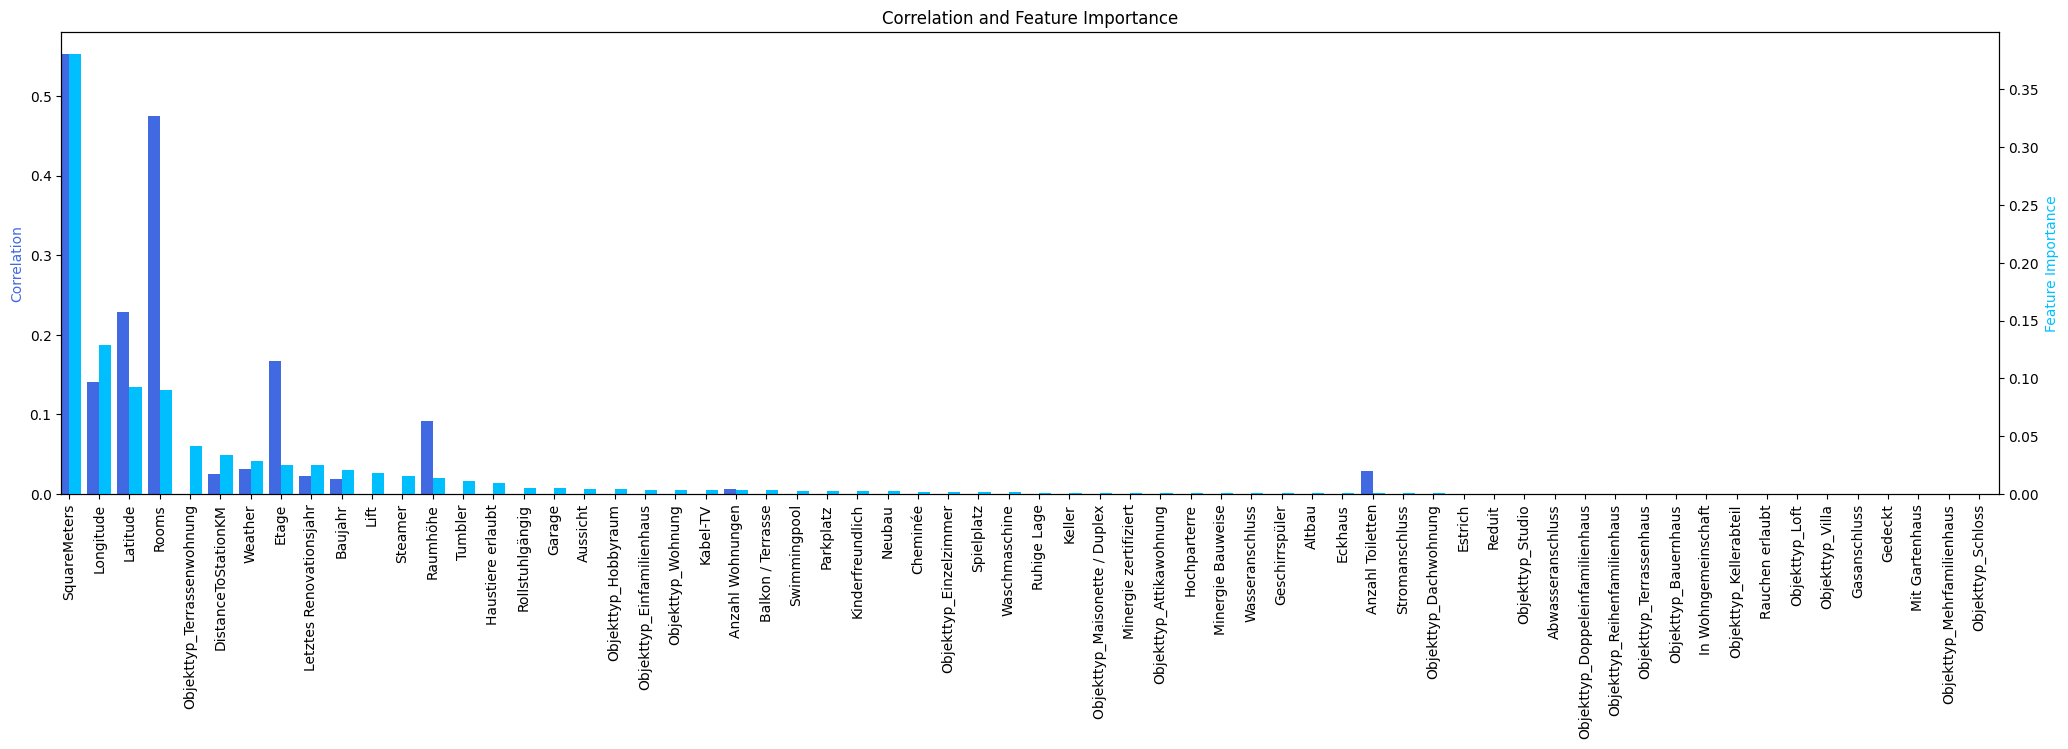

In [80]:
fig = plt.figure(figsize=(25, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

feature_info.correlation.plot(kind='bar', color='royalblue', ax=ax, width=width, position=1)
feature_info.feature_importance.plot(kind='bar', color='deepskyblue', ax=ax2, width=width, position=0)

ax.set_ylabel('Correlation', color='royalblue')
ax2.set_ylabel('Feature Importance', color='deepskyblue')
ax.set_xticklabels(feature_info['feature'], rotation=90)


plt.title('Correlation and Feature Importance')
plt.show()

Nice, our calculated features are among the top features. However, many features don't necessarily have a big impact on the model result.  

#### Feature Reduction 
In order to make the model more generic and more precise. It is an additional option to remove some Features. 
> (Li, 2022)

For this reason, we will drop most of the features and keep the top features from the last plot up to the feature "Raumhöhe".

In a last state of this projetct we run the best model again and compare the results. 

To start with, we create new data sets with reduced features and build a new Train/Test split:

In [111]:
# Drop features with low importance
print(X.shape)
features = feature_info['feature'].head(13).to_list()
features
X = X.loc[:, features]
X.shape

(983, 13)


(983, 13)

In [112]:
# Split the reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((786, 13), (786,))

### Final Model Run
Random Forest with reduced features:

In [113]:
# Create a Random Forest Regressor model
rfr_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rfr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rfr_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rfr_rmse = np.sqrt(rfr_mse)

# Calculate the R-squared value
rfr_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {rfr_mse:.2f}, Root Mean Squared Error: {rfr_rmse:.2f}, R²: {rfr_r2:.2f}')

Mean Squared Error: 0.00, Root Mean Squared Error: 0.06, R²: 0.74


### Use real Data instead of scaled data
Moreover, since we are working with a random forest model, the scaling of the variables does not matter that much. The scaled variables can actually be used to predict real values. For this reason, we use the unscaled variables again:

In [173]:
# get not scaled data
df_raw = pd.read_csv('data/immoscout24_zh_with_coordinates&distance&weather.csv', sep=';')

#drop the castel
print("before droping the castel:", df_raw.shape)
# get the most expensive propertys
castel_indices = df_raw[df_raw['Rooms'] == 20].index
# drop the most expensive propertys
df_raw.drop(castel_indices, inplace=True) 
df_raw.reset_index(drop=True, inplace=True)
print("after droping the castel:", df_raw.shape)

# create Feature / Label Split
X_non_scale = df_raw.drop(columns=['Price'])
y_non_scale = df_raw['Price']



# Train Test Split
# Split the data into training and testing sets
X_train_non_scale, X_test_non_scale, y_train_non_scale, y_test_non_scale = train_test_split(X_non_scale, y_non_scale, test_size=0.2, random_state=42)

before droping the castel: (985, 65)
after droping the castel: (983, 65)


In [174]:
# Create a Random Forest Regressor model
rfr_model_for_non_scale = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rfr_model_for_non_scale.fit(X_train_non_scale, y_train_non_scale)

# Make predictions on the test data
y_pred_non_scale = rfr_model_for_non_scale.predict(X_test_non_scale)

# Calculate the Mean Squared Error (MSE)
rfr_mse = mean_squared_error(y_test_non_scale, y_pred_non_scale)

# Calculate the Root Mean Squared Error (RMSE)
rfr_rmse = np.sqrt(rfr_mse)

# Calculate the R-squared value
rfr_r2 = r2_score(y_test_non_scale, y_pred_non_scale)

print(f'Mean Squared Error: {rfr_mse:.2f}, Root Mean Squared Error: {rfr_rmse:.2f}, R²: {rfr_r2:.2f}')

Mean Squared Error: 836417.73, Root Mean Squared Error: 914.56, R²: 0.74


In [175]:
feature_importance_for_non_scale = pd.DataFrame({"feature": X_train_non_scale.columns, "feature_importance": rfr_model_for_non_scale.feature_importances_})
feature_importance_for_non_scale = feature_importance_for_non_scale.sort_values(by='feature_importance', ascending=False)
feature_importance_for_non_scale

feature  feature_importance
1                      SquareMeters        3.813809e-01
61                        Longitude        1.296931e-01
60                         Latitude        9.173003e-02
0                             Rooms        8.819859e-02
57       Objekttyp_Terrassenwohnung        4.169507e-02
62              DistanceToStationKM        3.242488e-02
63                          Weather        2.835989e-02
2                             Etage        2.673656e-02
6           Letztes Renovationsjahr        2.464503e-02
3                           Baujahr        2.197086e-02
28                             Lift        1.800137e-02
29                          Steamer        1.579825e-02
4                          Raumhöhe        1.396203e-02
16                          Tumbler        1.178504e-02
11                Haustiere erlaubt        9.433691e-03
19                  Rollstuhlgängig        5.727199e-03
30                           Garage        4.414959e-03
48              Objekttyp_Hobbyraum        3.872955e-03
59                Objekttyp_Wohnung        3.773219e-03
33                         Aussicht        3.595794e-03
46        Objekttyp_Einfamilienhaus        3.339420e-03
10                         Kabel-TV        3.195545e-03
5                  Anzahl Wohnungen        3.016601e-03
36                     Swimmingpool        2.926988e-03
38                 Kinderfreundlich        2.915233e-03
20                Balkon / Terrasse        2.817445e-03
14                        Parkplatz        2.216886e-03
24                           Neubau        2.190216e-03
25                         Cheminée        1.980620e-03
47           Objekttyp_Einzelzimmer        1.687036e-03
21                       Spielplatz        1.590901e-03
9                     Waschmaschine        1.491833e-03
31                      Ruhige Lage        1.328854e-03
51    Objekttyp_Maisonette / Duplex        9.851072e-04
42          Objekttyp_Attikawohnung        9.495364e-04
15                Minergie Bauweise        9.130743e-04
17                           Keller        8.976614e-04
32                     Hochparterre        8.854239e-04
34                           Reduit        8.639505e-04
39                  Wasseranschluss        8.541764e-04
26            Minergie zertifiziert        8.246550e-04
40                   Geschirrspüler        7.456210e-04
37                          Eckhaus        7.229710e-04
22                           Altbau        6.761748e-04
7                  Anzahl Toiletten        6.062731e-04
23                   Stromanschluss        4.461679e-04
44            Objekttyp_Dachwohnung        4.407488e-04
35                Abwasseranschluss        2.885540e-04
55                 Objekttyp_Studio        2.058893e-04
45  Objekttyp_Doppeleinfamilienhaus        1.619522e-04
18                          Estrich        1.588517e-04
53     Objekttyp_Reihenfamilienhaus        1.326511e-04
56          Objekttyp_Terrassenhaus        1.168754e-04
27                  Rauchen erlaubt        5.341295e-05
49           Objekttyp_Kellerabteil        4.400621e-05
43             Objekttyp_Bauernhaus        4.282680e-05
41              In Wohngemeinschaft        3.677667e-05
8                      Gasanschluss        1.860003e-05
50                   Objekttyp_Loft        1.729731e-05
58                  Objekttyp_Villa        1.132332e-05
12                          Gedeckt        1.929941e-06
13                   Mit Gartenhaus        6.358309e-07
52       Objekttyp_Mehrfamilienhaus        0.000000e+00
54                Objekttyp_Schloss        0.000000e+00

In [177]:
# Drop features with low importance
relevant_features = feature_importance_for_non_scale['feature'].head(13).to_list()

X_non_scale = X_non_scale.loc[:, relevant_features]
X_non_scale.shape

# Split the reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_non_scale, y_non_scale, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rfr_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rfr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfr_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rfr_mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rfr_rmse = np.sqrt(rfr_mse)

# Calculate the R-squared value
rfr_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {rfr_mse:.2f}, Root Mean Squared Error: {rfr_rmse:.2f} CHF, R²: {rfr_r2:.2f}')

Mean Squared Error: 834721.43, Root Mean Squared Error: 913.63 CHF, R²: 0.74


#### Interpret the result
Now we have a RMSE of **900 Swiss Francs**.

## Conclusion
With 13  features in place, we are now able to forecast the price of apartments and houses in the Canton of Zurich with a high degree of accuracy.


---

At the very end: freeze the requirements in a requirements.txt file with the command: `pip freeze > requirements.txt` and load the requirements with the command: `pip install -r requirements.txt` at the top of the script

In [178]:
# freeze the dependencies
!pip freeze > requirements.txt

## Sources
- Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow: Techniques and Tools to Build Learning Machines. O’Reilly Media.
- Li, S. (2022, July 21). Best practice to calculate and interpret model feature importance. Medium. Retrieved May 7, 2024, from https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

### Jupyter Notebook - Footer Info

In [179]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-05-25 22:21:09
Python Version: 3.11.7
-----------------------------------
